<a href="https://colab.research.google.com/github/DamaKubu/Chat-Human/blob/main/FinalCountdownFFBAKIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotekos



In [1]:
# Install tqdm if it's not already available
!pip install tqdm

# Example of using tqdm
from tqdm import tqdm as wait

#for i in wait(range(5)):
#    time.sleep(0.1)


In [2]:
#Pips

!pip install MFDFA
!pip install hurst
!pip install fbm
!pip install hurst

In [3]:
#pagal https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/
#coocbook
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
## imports

from scipy.stats import levy_stable

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import time
from hurst import compute_Hc


from fbm import FBM
import math
from scipy import stats

# Imports
from MFDFA import MFDFA
from MFDFA import fgn
# where this second library is to generate fractional Gaussian noises


from hurst import compute_Hc, random_walk


plt.rcParams["figure.figsize"] = (5,5)
## constants and shit

from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import stats
# Two-sided inverse Students t-distribution
from scipy.stats import t
# plt.figure()
# plt.subplot(311) #subplot(nrows, ncols, index, **kwargs)
# plt.scatter(x, y, s=0.0001)
# plt.subplot(312)
def plotLinearFit(x,y,xlabel='xlabel',ylabel='ylabel',plot=True,s=0.05):
    # p - probability, df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    res = stats.linregress(x, y)
    if plot == True:
        Nuokrypis = f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f} \n intercept (95%): {res.intercept:.6f} +/- {ts*res.intercept_stderr:.6f}\n using Students two-sided t-distribution"
        plt.figure(figsize=(10,5))
        plt.scatter(x,y,s,label='original data')
        plt.plot(x, res.intercept + res.slope*x, 'r', label=Nuokrypis)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    return res.slope

# Funkcijos

In [14]:
 #@title Higuchi

 def higuchi1(a, k_max = 10):
        L = []
        x = []
        N = len(a)

        for k in range(1,k_max):
            Lk = 0
            for m in range(0,k):
                #we pregenerate all idxs
                idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
                Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
                Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
                Lk += Lmk

            L.append(np.log(Lk/(m+1)))
            x.append([np.log(1.0/ k), 1])

        (p, r1, r2, s)=np.linalg.lstsq(x, L,rcond=-1)
        return 2-p[0]


In [5]:
#@title R/S analysis
def myRS(xx):
    H, c, data = compute_Hc(xx, kind='random_walk', simplified=False)
    return H


In [6]:
#@title myMSD
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

def myMSD(series, plot = None):
    N = len(series)
    T = min(100, N // 2)  # You can adjust T depending on the series length
    tau_values = np.arange(1, T + 1)
    MSD = np.zeros(T)

    for i, tau in enumerate(tau_values):
        squared_displacements = (series[tau:] - series[:-tau]) ** 2
        MSD[i] = np.mean(squared_displacements)

    log_tau = np.log(tau_values)
    log_MSD = np.log(MSD)

    slope, intercept, r_value, p_value, std_err = linregress(log_tau, log_MSD)

    if plot!=None:
        # Plotting the MSD curve
        plt.figure(figsize=(4, 3))
        plt.plot(tau, MSD, 'o', label='Log-Log MSD Data')

        plt.plot(tau, np.exp(intercept + slope * log_tau), 'r', label=f'Pritaikyta tiesė (H = {slope/2:.2f})')
        plt.yscale('log')
        plt.xscale('log')

        plt.xlabel(r'$\tau$')
        plt.ylabel('MSD')
        plt.title('Log-Log ')
        plt.legend()
        plt.grid(True)
        plt.show()

    return slope / 2  # Hurst exponent


In [7]:
#@title MF-HDA

# MF-HDA.py                   C. Carrizales-Velazquez 21 April 2021
#
#
#-------------------------------------------------------------------------------------------
# MF-HDA: Calculate the Multifractal Higuchi Dimension Analysis (MF-HDA) of our paper: "Generalization of Higuchi’s fractal dimension for multifractal analysis of short time series"
#
# This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY
#
#-------------------------------------------------------------------------------------------

# Usage:
#
#  $ python3 MF-HDA.py -5 5 0.25 First_10K_integrated_Ulysses_Book.dat 25 0 15 16 Ulysses
#
# where:
#  ---> -5 is the minimum q-moment of L(q,k)
#  ---> 5 is the maximum q-moment of L(q,k)
#  ---> 0.25 is the separation between q-moments used in the MF-HDA
#  ---> First_10K_integrated_Ulysses_Book.dat is the file to read (this contain the time-series to analyze)
#  ---> 25 is the value initial scale k used in the MF-HDA
#  ---> 0 indicates the maximum scale k used in the MF-HDA (IF IT IS ZERO THEN THIS PROGRAM TAKE N/10, where N=length of time-series)
#  ---> 15 is p_r
#  ---> 16 is the number of bins used in the histogram for the expectation of Delta_X (for more details see section 2.2 of our publication: "Generalization of Higuchi’s fractal dimension for multifractal analysis of short time series")
#  ---> Ulysses is the name of outfiles
#
# these inputs can be changed as you want

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, sys

# save the inputs
#q_min = float(sys.argv[1]); q_max = float(sys.argv[2]); dq = float(sys.argv[3]); FILE = str(sys.argv[4]); ini = int(sys.argv[5]); fin = int(sys.argv[6]); PerI = int(sys.argv[7]); PerF = 100; Nbins=int(sys.argv[8]); name = str(sys.argv[9]);M=[];Q=np.arange(q_min-dq,q_max+2*dq,dq);NQ=len(Q)
def MF_HDA(x):
    q_min = -5#float(sys.argv[1]);
    q_max = 5#float(sys.argv[2]);
    dq = 0.25#float(sys.argv[3]);
    FILE ='Nofile.txt'#str(sys.argv[4]);
    ini = 25 #int(sys.argv[5]);
    fin = 0 #int(sys.argv[6]);
    PerI = 15#int(sys.argv[7]);
    PerF = 100;
    Nbins= 16 #int(sys.argv[8]);
    name = 'sexy time'#str(sys.argv[9]);
    M=[];
    Q=np.arange(q_min-dq,q_max+2*dq,dq);
    NQ=len(Q)


    ##################################################### create a folder to save the results there
    def createFolder(directory):
        try:
            if not os.path.exists(directory):
                os.makedirs(directory)
        except OSError:
            print ('Error: Creating directory. ' + directory)

    createFolder('MFH_P_'+str(PerI)+'-100_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/')
    ####################################################

    for j in range(NQ+1):
        M.append([]) # create the array for L(q,k)

    # reading data
    #data = np.loadtxt(FILE); x = data.transpose()



    N = len(x); k = ini # set the initial scale k

    # define the end of the scale k
    if fin == 0:
        KF=N/10
    else:
        KF=fin

    wbin = 100/Nbins # width of bins are calculated
    while k <= KF:
        M[0].append(k);subN=[];L=[] # M[0] save the scale k

        preDx =[]
        for pm in range(k):
            m = pm + 1
            pDx = abs(np.diff(x[m-1:N:k])); preDx.append(pDx[pDx != 0]) # calculate the Delta_X for each scale k and for each m-value (for more details see section 2.1 of our paper). We also discard vales of Delta_X=0, this will produce incosistencies for negative q-moments

        Dx = np.concatenate(preDx) # we join all the m-subseries of Delta_X
        FI = np.percentile(Dx, PerI); FS = np.percentile(Dx, PerF); Dx = Dx[ Dx >= FI]; Dx = Dx[ Dx <= FS];	bin_edges = [] # we remove data according to p_r
        for i in np.arange(0,100+wbin, wbin):
            bin_edges.append(np.percentile(Dx, i)) # we set the bin_edges in order to get equi-probable bins

        BE = np.array(bin_edges); X=[]
        for i in range(len(BE)-1):
            X.append([]) # we create void-arrays for regrouping Delta_X according to its bin-belonging

        for i in range(len(BE)-1):
            for j in Dx:
                if i == 0: # just first bin should be a close interval
                    if j >= BE[i] and j <= BE[i+1]:
                        X[i].append(j) # we save Delta_X according to each bin-belonging
                else:
                    if j > BE[i] and j <= BE[i+1]:
                        X[i].append(j) # we save Delta_X according to each bin-belonging

        W = (np.diff(BE)); H = np.histogram(Dx, bins = BE, density=True); P = H[0] * W  # calculate the probability of each bin
        for I in range(NQ):
            preL=[]; subNDX=[]
            if Q[I] == 0:
                for i in X:
                    subNDX.append( (np.log(np.array(i))) / len(i)) # we save the q-moments of Delta_X (this line is for q=0)
            else:
                for i in X:
                    subNDX.append( (np.array(i)**Q[I]) / len(i)) # we save the q-moments of Delta_X

            for i,j in zip(subNDX, P):
                for a in i:
                    preL.append(a * j) # calculate elements of expected Delta_X

            L.append(sum(preL)) # calculate the expected Delta_X
        for i in range(NQ):
            if Q[i] == 0:
                M[i+1].append((float(N-1)/k**2) *  np.exp(L[i]) ) # calculate the L(q,k) for q=0
            else:
                M[i+1].append((float(N-1)/k**2) *  L[i]**(1.0/Q[i]) ) # calculate the L(q,k)

        k = int(k*np.sqrt(np.sqrt(2))) + 1 # the increment of scale k is logarithmic (note that k <= fin, where fin is an input (line 34 of original version))

    np.savetxt('MFH_P_'+str(PerI)+'-'+str(PerF)+'_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/PF_'+name+'.txt',np.matrix(M).transpose(),fmt='%s') # save the L(q,k) in the folder created

    MHT=[[],[],[]]; MHT[0]=Q # MHT will contain info of hölder and tau function
    for i in range(NQ):
        h = 2 + np.polyfit(np.log10(M[0]),np.log10(M[i+1]),1)[0] # hölder is calculated
        MHT[1].append(h);MHT[2].append(Q[i]*h-1) # hölder and tau function are set in MHT

    np.savetxt('MFH_P_'+str(PerI)+'-'+str(PerF)+'_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/h_tau-spectrum_'+name+'.txt',np.matrix(MHT).transpose(),fmt='%s') # hölder and tau are saved in the folder created

    Maf=[[],[]]
    for k in range(1,NQ-1):
        a=( (MHT[2][k+1]-MHT[2][k-1])/(2*dq) ) # calculate alpha
        Maf[0].append(a); Maf[1].append(MHT[0][k]*a-MHT[2][k]) # calculate multifractal spectrum f(alpha)

    np.savetxt('MFH_P_'+str(PerI)+'-'+str(PerF)+'_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/MF-spectrum_'+name+'.txt',np.matrix(Maf).transpose(),fmt='%s') # multifractal spectrum is saved in the folder created

    # finally we create the figure of the results as figures 3 and 4 of our paper
    sns.set_style('darkgrid')

    grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.45)
    plt.figure(figsize=(9.5, 6))

    plt.subplot(grid[0,1])
    plt.plot(MHT[0], MHT[1])
    plt.xlabel('q', fontsize=16, fontstyle='italic')
    plt.ylabel('h(q)', fontsize=16, fontstyle='italic')
    plt.grid(True, which="both")

    plt.subplot(grid[1,1])
    plt.plot(MHT[0], MHT[2])
    plt.xlabel('q', fontsize=16, fontstyle='italic')
    plt.ylabel(r'$\tau$(q)', fontsize=16, fontstyle='italic')
    plt.grid(True, which="both")

    plt.subplot(grid[2,1])
    plt.plot(Maf[0], Maf[1])
    plt.xlabel(r'$\alpha$', fontsize=16, fontstyle='italic')
    plt.ylabel(r'f($\alpha$)', fontsize=16, fontstyle='italic')
    plt.grid(True, which="both")

    plt.subplot(grid[0:, 0])
    for i in range(len(M)-1):
        plt.plot(M[0], M[i+1])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Scale k', fontsize=18, fontstyle='italic')
    plt.ylabel('Generalized length L(q,k)', fontsize=18, fontstyle='italic')
    plt.grid(True, which="both")

    plt.suptitle(r'MF-HDA of '+name+' with $p_r=$'+str(PerI)+'', fontsize=20, style='italic') # title is created with the name of the inputs

    plt.savefig('MFH_P_'+str(PerI)+'-'+str(PerF)+'_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/'+name+'.jpg') # save figure
    plt.show() # also this figure is shown

In [ ]:
#@title MF_HDA_for one graph

# save the inputs
#q_min = float(sys.argv[1]); q_max = float(sys.argv[2]); dq = float(sys.argv[3]); FILE = str(sys.argv[4]); ini = int(sys.argv[5]); fin = int(sys.argv[6]); PerI = int(sys.argv[7]); PerF = 100; Nbins=int(sys.argv[8]); name = str(sys.argv[9]);M=[];Q=np.arange(q_min-dq,q_max+2*dq,dq);NQ=len(Q)
def MF_HDA_one_graph(x):
    q_min = -10#float(sys.argv[1]);
    q_max = 10#float(sys.argv[2]);
    dq = 1#float(sys.argv[3]);
    FILE ='Nofile.txt'#str(sys.argv[4]);
    ini = 25 #int(sys.argv[5]);
    fin = 0 #int(sys.argv[6]);
    PerI = 15#int(sys.argv[7]);
    PerF = 100;
    Nbins= 16 #int(sys.argv[8]);
    name = 'sexy time'#str(sys.argv[9]);
    M=[];
    Q=np.arange(q_min-dq,q_max+2*dq,dq);
    NQ=len(Q)


    ##################################################### create a folder to save the results there
    def createFolder(directory):
        try:
            if not os.path.exists(directory):
                os.makedirs(directory)
        except OSError:
            print ('Error: Creating directory. ' + directory)

    createFolder('MFH_P_'+str(PerI)+'-100_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/')
    ####################################################

    for j in range(NQ+1):
        M.append([]) # create the array for L(q,k)

    # reading data
    #data = np.loadtxt(FILE); x = data.transpose()



    N = len(x); k = ini # set the initial scale k

    # define the end of the scale k
    if fin == 0:
        KF=N/10
    else:
        KF=fin

    wbin = 100/Nbins # width of bins are calculated
    while k <= KF:
        M[0].append(k);subN=[];L=[] # M[0] save the scale k

        preDx =[]
        for pm in range(k):
            m = pm + 1
            pDx = abs(np.diff(x[m-1:N:k])); preDx.append(pDx[pDx != 0]) # calculate the Delta_X for each scale k and for each m-value (for more details see section 2.1 of our paper). We also discard vales of Delta_X=0, this will produce incosistencies for negative q-moments

        Dx = np.concatenate(preDx) # we join all the m-subseries of Delta_X
        FI = np.percentile(Dx, PerI); FS = np.percentile(Dx, PerF); Dx = Dx[ Dx >= FI]; Dx = Dx[ Dx <= FS];	bin_edges = [] # we remove data according to p_r
        for i in np.arange(0,100+wbin, wbin):
            bin_edges.append(np.percentile(Dx, i)) # we set the bin_edges in order to get equi-probable bins

        BE = np.array(bin_edges); X=[]
        for i in range(len(BE)-1):
            X.append([]) # we create void-arrays for regrouping Delta_X according to its bin-belonging

        for i in range(len(BE)-1):
            for j in Dx:
                if i == 0: # just first bin should be a close interval
                    if j >= BE[i] and j <= BE[i+1]:
                        X[i].append(j) # we save Delta_X according to each bin-belonging
                else:
                    if j > BE[i] and j <= BE[i+1]:
                        X[i].append(j) # we save Delta_X according to each bin-belonging

        W = (np.diff(BE)); H = np.histogram(Dx, bins = BE, density=True); P = H[0] * W  # calculate the probability of each bin
        for I in range(NQ):
            preL=[]; subNDX=[]
            if Q[I] == 0:
                for i in X:
                    subNDX.append( (np.log(np.array(i))) / len(i)) # we save the q-moments of Delta_X (this line is for q=0)
            else:
                for i in X:
                    subNDX.append( (np.array(i)**Q[I]) / len(i)) # we save the q-moments of Delta_X

            for i,j in zip(subNDX, P):
                for a in i:
                    preL.append(a * j) # calculate elements of expected Delta_X

            L.append(sum(preL)) # calculate the expected Delta_X
        for i in range(NQ):
            if Q[i] == 0:
                M[i+1].append((float(N-1)/k**2) *  np.exp(L[i]) ) # calculate the L(q,k) for q=0
            else:
                M[i+1].append((float(N-1)/k**2) *  L[i]**(1.0/Q[i]) ) # calculate the L(q,k)

        k = int(k*np.sqrt(np.sqrt(2))) + 1 # the increment of scale k is logarithmic (note that k <= fin, where fin is an input (line 34 of original version))

    np.savetxt('MFH_P_'+str(PerI)+'-'+str(PerF)+'_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/PF_'+name+'.txt',np.matrix(M).transpose(),fmt='%s') # save the L(q,k) in the folder created

    MHT=[[],[],[]]; MHT[0]=Q # MHT will contain info of hölder and tau function
    for i in range(NQ):
        h = 2 + np.polyfit(np.log10(M[0]),np.log10(M[i+1]),1)[0] # hölder is calculated
        MHT[1].append(h);MHT[2].append(Q[i]*h-1) # hölder and tau function are set in MHT

    np.savetxt('MFH_P_'+str(PerI)+'-'+str(PerF)+'_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/h_tau-spectrum_'+name+'.txt',np.matrix(MHT).transpose(),fmt='%s') # hölder and tau are saved in the folder created

    Maf=[[],[]]
    for k in range(1,NQ-1):
        a=( (MHT[2][k+1]-MHT[2][k-1])/(2*dq) ) # calculate alpha
        Maf[0].append(a); Maf[1].append(MHT[0][k]*a-MHT[2][k]) # calculate multifractal spectrum f(alpha)

    np.savetxt('MFH_P_'+str(PerI)+'-'+str(PerF)+'_'+name+'_ki'+str(ini)+'_kf'+str(fin)+'_Nbins'+str(Nbins)+'/MF-spectrum_'+name+'.txt',np.matrix(Maf).transpose(),fmt='%s') # multifractal spectrum is saved in the folder created

    # finally we create the figure of the results as figures 3 and 4 of our paper
    sns.set_style('darkgrid')

    #grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.45)
    #plt.figure(figsize=(9.5, 6))

   #plt.subplot(grid[0,1])
    #plt.plot(MHT[0], MHT[1])
    #plt.xlabel('q', fontsize=16, fontstyle='italic')
    #plt.ylabel('h(q)', fontsize=16, fontstyle='italic')
    #plt.grid(True, which="both")

    return MHT[0], MHT[1]

# New Section

In [ ]:
from hurst import compute_Hc, random_walk #gal galiu tsg compute_HC naudot?


plt.rcParams["figure.figsize"] = (5,5)
## constants and shit

from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import stats
# Two-sided inverse Students t-distribution
from scipy.stats import t
# plt.figure()
# plt.subplot(311) #subplot(nrows, ncols, index, **kwargs)
# plt.scatter(x, y, s=0.0001)
# plt.subplot(312)
def plotLinearFit(x,y,xlabel='xlabel',ylabel='ylabel',plot=True,s=0.05):
    # p - probability, df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    res = stats.linregress(x, y)
    if plot == True:
        Nuokrypis = f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f} \n intercept (95%): {res.intercept:.6f} +/- {ts*res.intercept_stderr:.6f}\n using Students two-sided t-distribution"
        plt.figure(figsize=(10,5))
        plt.scatter(x,y,s,label='original data')
        plt.plot(x, res.intercept + res.slope*x, 'r', label=Nuokrypis)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    return res.slope

In [ ]:
#
def skirstinys(xx, e1, e2, N=100, k = 0.1, x_pradinis = 0, TT = 10000, bins = 40 ):

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(7, 4))

    epsilonai = f"$\\epsilon_1 = ${e1:2.2f},   $\\epsilon_2 = ${e2:2.2f}"
    parametrai = f"\n N = {N}, $x_0$ = {x_pradinis}, iteracijos = {TT}"



    #xx
    ax[0].set_title(f"Gautas tikimybės skirstinys: "+epsilonai+parametrai)
    counts, bins = np.histogram(xx, bins = bins )
    ax[0].stairs(counts, bins)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("kiekis");

    #teorinis gamma
    C = 1/sc.beta(e1, e2)#m.gamma(e1+e2)/(m.gamma(e2)*m.gamma(e1))
    bb = np.linspace(0,1,100)

    ax[1].set_title(f"Teorinis tikimybės skirstinys:\n "+epsilonai)
    ax[1].plot(bb,C*bb**(e1-1)*(1-bb)**(e2-1));
    ax[1].set_xlabel("$\\frac{X}{N}$")
    ax[1].set_ylabel("P($\\frac{X}{N}$)");





def plot_normhist(xx, bins = 30, ax = 0, ribos = 'auto',*args, **kwargs):

    # Apskaičiuojame histogramą ir bin ribas
    hist, bin_edges = np.histogram(xx, bins=bins, density=True)

    # Skaičiuojame plotą po kreive, kad užtikrintume normalizavimą
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    hist_area = np.sum((bin_edges[1:] - bin_edges[:-1]) * hist)

    if ax == 0:
        fig, ax = plt.subplots(1,1, figsize = (4,3))

    ax.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.8, color='#117711',*args, **kwargs)
    ax.set_xlabel('xx')
    ax.set_ylabel('PDF')


#naujas plotinimo protokolas
#do_something() ABT: Action but something Therefore do_something(). <3
#do_howwhat
#paduodu, xx, bins ir subploto axis ir galiu plotint viduje!
def plot_loghist(xx, bins = 30, ax = 0, neigiami = False, *args, **kwargs):
    #take out the 0's cuz log ain't defined
    xx = list(filter(lambda i: i != 0, xx))

    #split positive and negative parts
    #yes it's ugly, but it's more self contained..
    from collections import defaultdict

    d = defaultdict(list)

    for num in xx:
        if num < 0:
            d['neg'].append(num)
        else: # This will also append zero to the positive list, you can change the behavior by modifying the conditions
            d['pos'].append(num)



    if neigiami == True:
        xxn = np.array(d['neg'])*(-1)
        xxp = np.array(d['pos'])
        xx = np.concatenate((xxp,xxn), axis = 0)
    else:
        xx = d['pos']



    hist, bins = np.histogram(xx, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))


    #reiktu pirma normalizuot jog galeciau sakyti, kad cia itkimybe
    if ax == 0:
        fig, ax = plt.subplots(1,1, figsize = (4,3),layout='constrained')

    ax.hist(xx, bins=logbins, color = "#DC9F3B", *args, **kwargs)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('log(xx)')
    ax.set_ylabel('log(DF)')



In [ ]:
#plot the double

def plot_quadrupo(xx, H = None, title = None):
    #plotinimas ir multifraktališkumo paskaičiavimas
    fig, ax = plt.subplots(1,4, figsize=(14,2.6),layout='constrained')

    if title != None:
        fig.suptitle(title) #f'įvesties H = {H}, |dėžės dydis| = {box_size}, taškai = $10^{round(math.log10(steps))}$, tamprus = {tamprus}', fontsize=14, color = 'Green')



    #first plot, the data itself
    rodyk = 1000
    ax[0].plot(xx[:rodyk])
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('xx')
    ax[0].set_title(f'Pirmieji {rodyk} sekos taškai')

    #calculate and plot multifractality second plot
    # Select a band of lags, which usually ranges from
    # very small segments of data, to very long ones, as
    lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
    # Notice these must be ints, since these will segment
    # the data into chucks of lag size

    # The order of the polynomial fitting
    order = 1
    qq = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12]

    Hq = []
    for q in qq:
        # Obtain the (MF)DFA as
        lag, dfa = MFDFA(xx, lag = lag, q = q, order = order)
        # To uncover the Hurst index, lets get some log-log plots
        #plt.loglog(lag, dfa, '-', label='fOU: MFDFA q=2')

        # And now we need to fit the line to find the slope. Don't
        # forget that since you are plotting in a double logarithmic
        # scales, you need to fit the logs of the results
        H_hat = np.polyfit(np.log(lag)[4:20],np.log(dfa[4:20]),1)[0]
        Hq.append(H_hat)
        # Now what you should obtain is: slope = H + 1
        #print('Estimated H = '+'{:.3f}'.format(H_hat[0]))

    kiekPlotint = Hq.copy()
    kiekPlotint.append(0)
    kiekPlotint.append(1)
    ax[1].set_title(f'Multifraktališkumas max-min = {np.max(Hq)-np.min(Hq):2.2f}')
    ax[1].set_xlabel("q")
    #ax[1].set_ylim(-1,1.5)
    ax[1].set_ylabel("h(q)")
    if H != None:
        ax[1].scatter(qq, Hq, label= f"įvesties H = {H}", color = 'black')
    else:
        ax[1].scatter(qq, Hq)

    ax[1].grid(True)
    ax[1].legend()

    q, Hq = MF_HDA_one_graph(xx)
    ax[2].set_title(f"MF_HDA {np.max(Hq)-np.min(Hq):2.2f}")
    ax[2].plot(q, Hq )
    ax[2].set_xlabel('q', fontsize=16, fontstyle='italic')
    ax[2].set_ylabel('h(q)', fontsize=16, fontstyle='italic')




    #plot normuota histogramą
    plot_normhist(xx, ax = ax[3], bins = 30)
    ax[3].set_title(f"Normuotas skirstinys")



    #plot log log histogramą
    #plot_loghist(xx, ax = ax[3], bins = 10, neigiami = True)
    #ax[2].set_title('log-log skirstinys')


In [ ]:
#@title judesys_dezeje_netamprus

def judesys_dezeje_netamprus(judesys, box_size):
    judesys_dezeje = []

    for value in judesys:
        if   value >  box_size:
            value  =  box_size

        elif value < -box_size:
            value  = -box_size

        judesys_dezeje.append(value)

    return np.array(judesys_dezeje)






In [ ]:
#@title  judesys_dezeje_tamprus


def judesys_dezeje_tamprus(judesys, box_size=1):
    """
    Generate an unbounded fractional Brownian motion and then apply mirror-style boundary conditions
    in a separate pass to ensure the motion remains within specified boundaries.

    Parameters:
    - noise (np.ndarray): An array of noise increments, representing the fractional Gaussian noise.
    - box_size (float): The size of the bounding box for the motion.

    Returns:
    - np.ndarray: The simulated bounded fractional Brownian motion after applying boundary conditions.
    """
    # Step 1: Generate unbounded FBM
    #unbounded_fbm = np.cumsum(noise)
    unbounded_fbm = judesys

    # Step 2: Apply boundary conditions in a separate pass
    bounded_fbm = np.zeros_like(unbounded_fbm)
    position = 0

    for i, position in enumerate(unbounded_fbm):
        # Reflect if the position goes outside the boundary nu sita gera yra!
        while abs(position) > box_size:
            if position > box_size:
                overshoot = position - box_size
                position = box_size - overshoot
            elif position < -box_size:
                overshoot = -box_size - position
                position = -box_size + overshoot

        bounded_fbm[i] = position

    return bounded_fbm

In [ ]:
def autokoreliacija_lag1(data_norm):
    alpha = np.corrcoef(data_norm[0:-1], data_norm[1:])[0,1];
    #print("Lag-1 autocorrelation = {:4.2f}".format(alpha))
    return alpha

In [ ]:
#@title judesys_dezeje_netamprus_begantis

def judesys_dezeje_netamprus_begantis(judesys, box_size):
    judesys_dezeje = []
    begantis = 0
    judesys_dezeje.append(begantis)
    dXX = judesys[1:]-judesys[:-1] #very good works as a charm!

    for dX in dXX:
        begantis += dX

        if begantis>box_size:
            begantis = box_size

        elif begantis<-box_size:
            begantis = -box_size

        judesys_dezeje.append(begantis)

    return np.array(judesys_dezeje)


#nemodifikuoja visiškai judesio, tsg iskaido ir vel sudeda
def nemodifikuotas(judesys, *args,**kwargs): #exactly the same!!!
    judesys_dezeje = []
    begantis = 0
    judesys_dezeje.append(begantis)
    dXX = judesys[1:]-judesys[:-1] #very good works as a charm!
    for dX in dXX:
        begantis += dX
        judesys_dezeje.append(begantis)

    return np.array(judesys_dezeje)



In [ ]:
#@title judesys_dezeje_kimbantis

def judesys_dezeje_kimbantis(judesys, box_size, P_kibimo =0.5):
    judesys_dezeje = []
    begantis = 0
    judesys_dezeje.append(begantis)
    dXX = judesys[1:]-judesys[:-1] #very good works as a charm!

    for dX in dXX:
        if abs(begantis) == box_size:
            #mesk kauliuka, jei iskris tada bus galima judet jei ne nejudesi niekur
            if np.random.random()>P_kibimo:
                begantis += dX
            #jei neiskrito toliau buk prikibęs
        else:
            begantis += dX
        #neperšokimas
        if begantis >box_size:
            begantis = box_size
        elif begantis < -box_size:
            begantis = -box_size

        judesys_dezeje.append(begantis)

    return np.array(judesys_dezeje)


Text(0.5, 1.0, 'Kimbanti kraštinė sąlyga P=0.7')

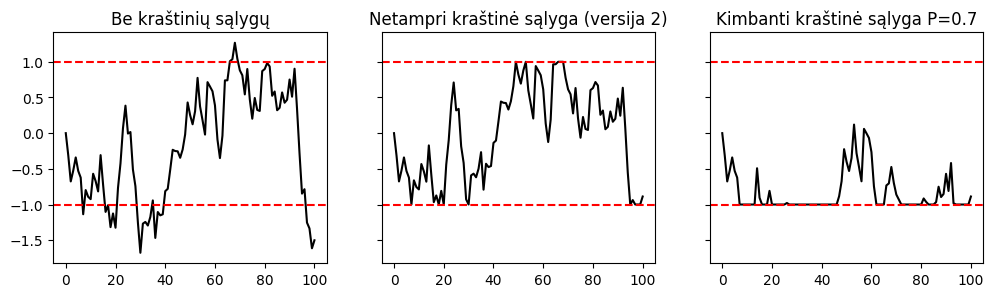

In [ ]:
f = FBM(n=100, hurst=0.5, length=10, method='daviesharte')
xx0 = f.fbm()

box_size = 1

fig, [ax0,ax1, ax2] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)


ax0.plot(xx0, color='black')
ax0.set_title('Be kraštinių sąlygų')
ax0.axhline(y=box_size, linestyle='--',color='red')
ax0.axhline(y=-box_size, linestyle='--',color='red')


xx1 = judesys_dezeje_netamprus_begantis(xx0, box_size = box_size)
ax1.plot(xx1, color='black')
ax1.axhline(y=box_size, linestyle='--',color='red')
ax1.axhline(y=-box_size, linestyle='--',color='red')
ax1.set_title('Netampri kraštinė sąlyga (versija 2)')


xx2 = judesys_dezeje_kimbantis(xx0, box_size = box_size, P_kibimo =0.7)
ax2.plot(xx2, color='black')
ax2.axhline(y=box_size, linestyle='--',color='red')
ax2.axhline(y=-box_size, linestyle='--',color='red')
ax2.set_title('Kimbanti kraštinė sąlyga P=0.7')


# EXTRA SPICY FUN


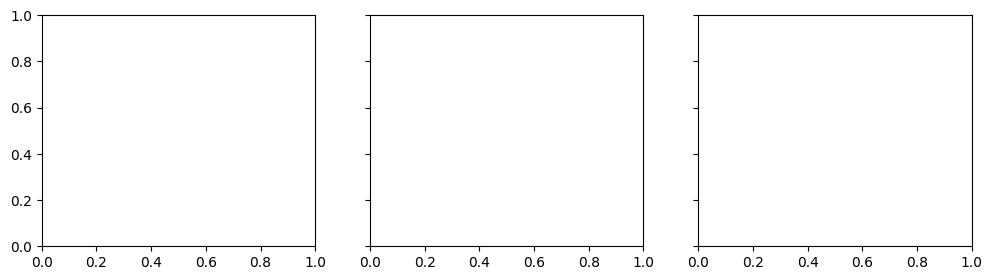

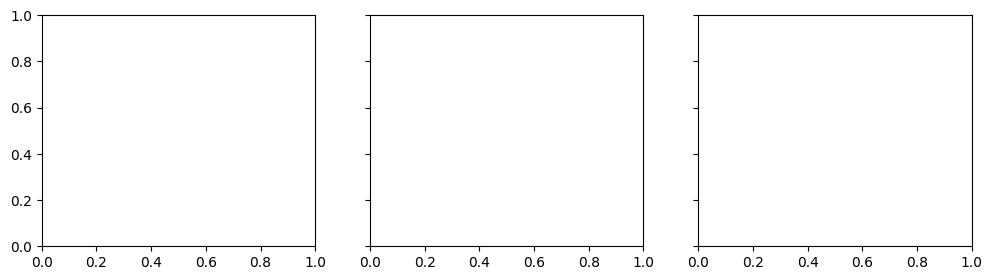

In [ ]:
#@title plot  fbm
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)

fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)



N = 1000


def FBM_hurst(ax, bx, beta=-1,  krastine_salyga = judesys_dezeje_netamprus,N = 1000, K =10,H_N = 100,title =None, **kwargs):
    hh_higuchi =[]
    hh_msd =[]
    hh_rs = []

    FAILED_higuchi = []
    FAILED_msd =[]
    FAILED_rs =[]


    hh  = np.linspace(0,1, H_N)[2:-2]

    for h in hh:
        #xx = levy_stable.rvs(alpha=a, beta=beta, size=N).cumsum()

        f = FBM(n=N, hurst=h, length=10, method='daviesharte')
        #paimam vidurki aritmetini kad grafikai nesokinetu tiek
        K_higuchi = K
        K_msd = K
        K_rs = K
        higuchi =0
        msd = 0
        rs = 0



        for _ in range(K):

            xx0 = f.fbm()[1:]
            if krastine_salyga!=None:
                xx = krastine_salyga(xx0,**kwargs)
            else:
                xx = xx0
            try:
                higuchi += 2-higuchi1(xx)
            except:
                K_higuchi -=1
                if K_higuchi <=0:
                    print("fuck higuchi")

            try:
                msd += myMSD(xx)
            except:
                K_msd -=1
                if K_msd <=0:
                    print("fuck msd")
            try:
                rs += myRS(xx)
            except:
                K_rs -=1
                if K_rs <=0:
                    print("fuck rs")

        FAILED_higuchi.append(10-K_higuchi)
        FAILED_msd.append(10-K_msd)
        FAILED_rs.append(10-K_rs)

        hh_higuchi.append( higuchi/K_higuchi )
        hh_msd.append(msd/K_msd)
        hh_rs.append(rs/K_rs)

    if title != None:
        ax.set_title(title)
    else:
        if krastine_salyga!=None:
            ax.set_title(f'FBM, dėžės dydis = {box_size}')
        else:
            ax.set_title(f'FBM be kraštinių sąlygų')


    R_higuchi = np.corrcoef(hh, hh_higuchi)[0,1];
    R_msd = np.corrcoef(hh, hh_msd)[0,1];
    R_rs = np.corrcoef(hh, hh_rs)[0,1];

    ax.plot(hh,hh_higuchi, label=r'Higuchi'+f' {R_higuchi:0.4f}', color='black', marker='o',linewidth = 1, markersize =2)
    ax.plot(hh,hh_msd, label = 'MSD'+f' {R_msd:0.4f}', color='blue', alpha = 0.7,marker='s',linewidth = 1, markersize =2)
    ax.plot(hh,hh_rs, label = 'R/S'+f' {R_rs:0.4f}', color='red', alpha = 0.7,marker='x',linewidth = 1, markersize =2)
    ax.set_xlabel(r'H (įvestis)')
    ax.set_ylabel(r'H (išvestis)')
    ax.plot(hh,hh, label='Teorinis', color='green', linewidth=0.6, linestyle ='--')

    ax.legend()

    try:
        bx.plot(hh, FAILED_higuchi, label=r'Higuchi', color='black', marker='o',linewidth = 1, markersize =2)
        bx.plot(hh, FAILED_msd, label = 'MSD', color='blue', alpha = 0.7,marker='s',linewidth = 1, markersize =3)
        bx.plot(hh, FAILED_rs, label = 'R/S', color='red', alpha = 0.7,marker='x',linewidth = 1, markersize =2)
        bx.set_xlabel(r'H (įvestis)')
        bx.set_ylabel(r'Algoritmas lūžo')
        bx.legend()
    except:
        print('fuckity')

#FBM_hurst(ax1,bx1, krastine_salyga=None)
#for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [1,0.01])):
#    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus, box_size =box_size)
#ax1.legend(loc='lower right')
#fig.suptitle('Netamprios kraštinės sąlygos',y=1.1)


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
3it [05:54, 118.24s/it]


Text(0.5, 1.1, 'Netamprios kraštinės sąlygos')

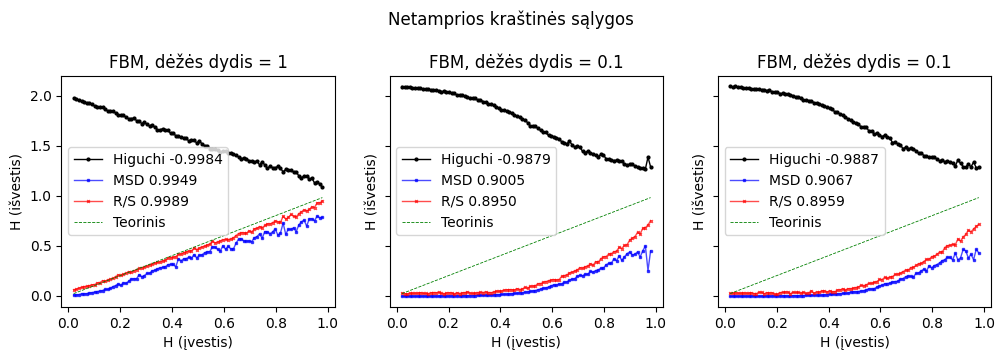

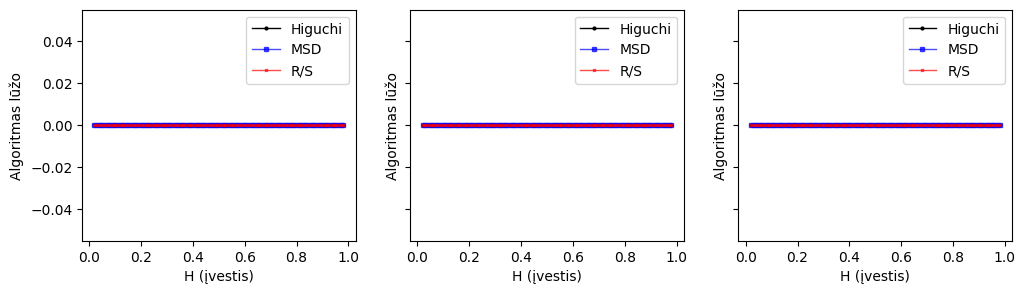

In [ ]:
#@title plot netamprus begantis dėžės for fbm

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, box_size in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3], [1,0.1,0.1])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus_begantis, box_size =box_size, N =1000, K = 10, H_N = 100)
fig.suptitle('Netamprios kraštinės sąlygos',y=1.1)

3it [05:37, 112.60s/it]


Text(0.5, 1.1, 'Netamprios kraštinės sąlygos')

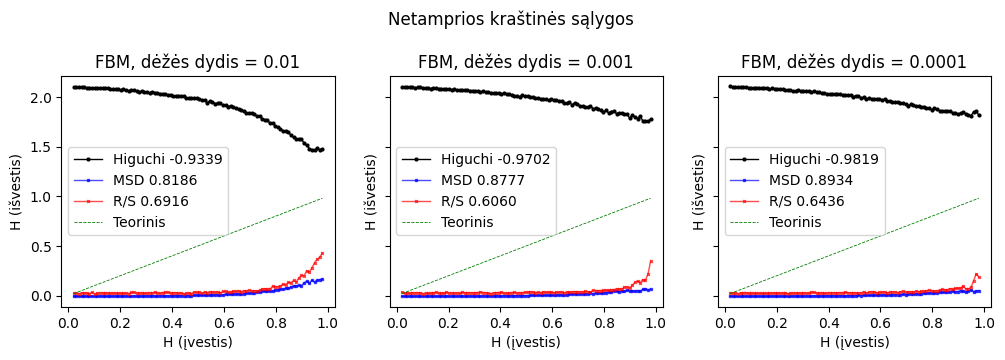

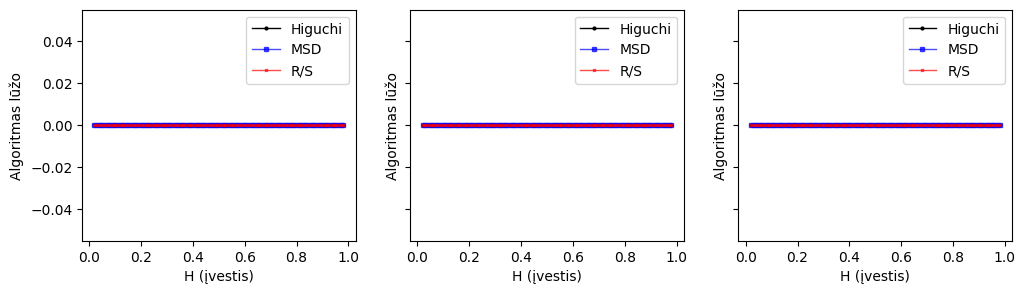

In [ ]:
#@title plot netamprus begantis dėžės for fbm

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, box_size in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3], [0.01,0.001,0.0001])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus_begantis, box_size =box_size, N =1000, K = 10, H_N = 100)
fig.suptitle('Netamprios kraštinės sąlygos',y=1.1)

3it [05:37, 112.42s/it]


Text(0.5, 1.1, 'Netamprios kraštinės sąlygos')

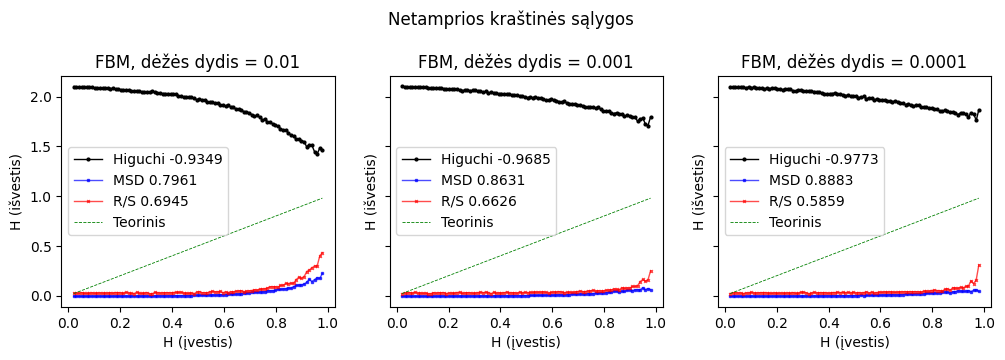

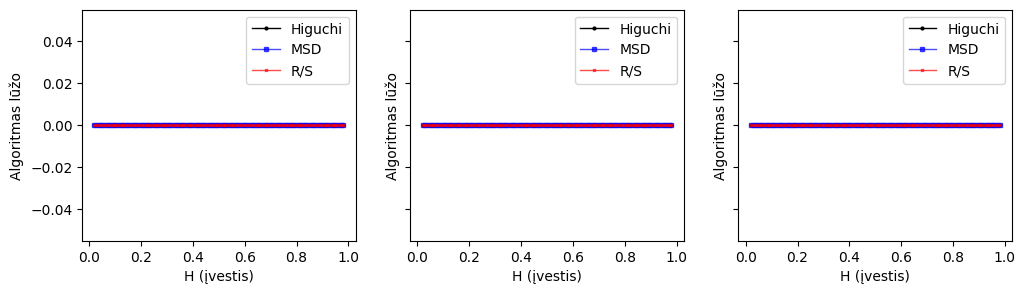

In [ ]:
#@title plot netampri dėžės for fbm
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, box_size in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3], [0.01,0.001,0.0001])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus_begantis, box_size =box_size, N =1000, K = 10, H_N = 100)
fig.suptitle('Netamprios kraštinės sąlygos',y=1.1)

3it [05:36, 112.32s/it]


Text(0.5, 1.1, 'Kimbančios kraštinės sąlygos')

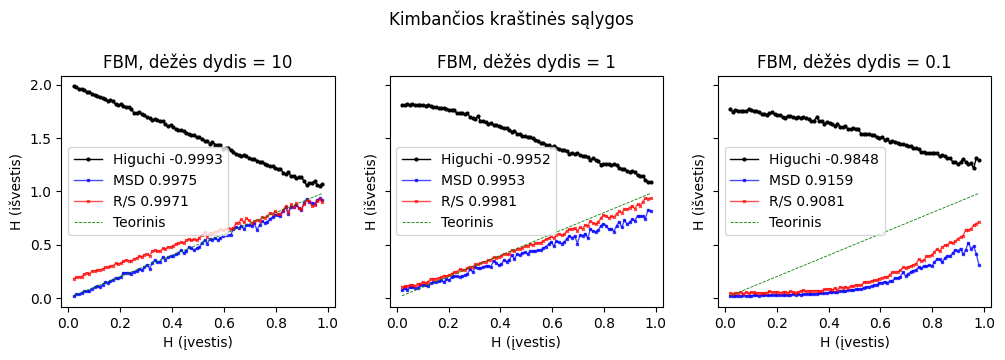

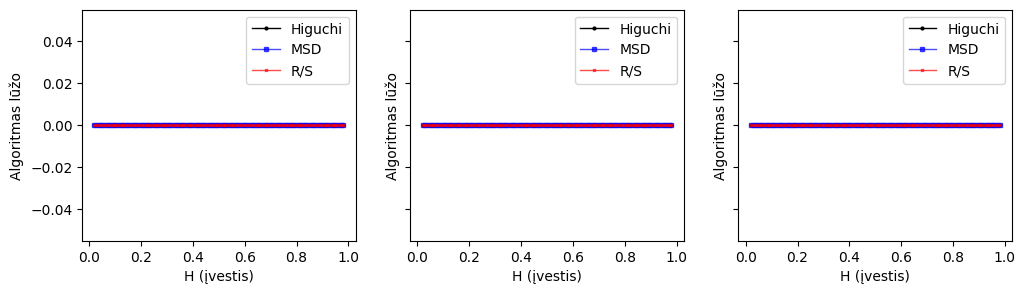

In [ ]:
#@title plot kimbanti dėžės for fbm

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, box_size in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3], [10,1,0.1])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_kimbantis, box_size =box_size, P_kibimo=0.5, N =1000, K = 10, H_N = 100)
fig.suptitle('Kimbančios kraštinės sąlygos',y=1.1)

3it [05:37, 112.67s/it]


Text(0.5, 1.1, 'Kimbančios kraštinės sąlygos, FBM, dėžės dydis 0.1, kinta kibimo stipris P')

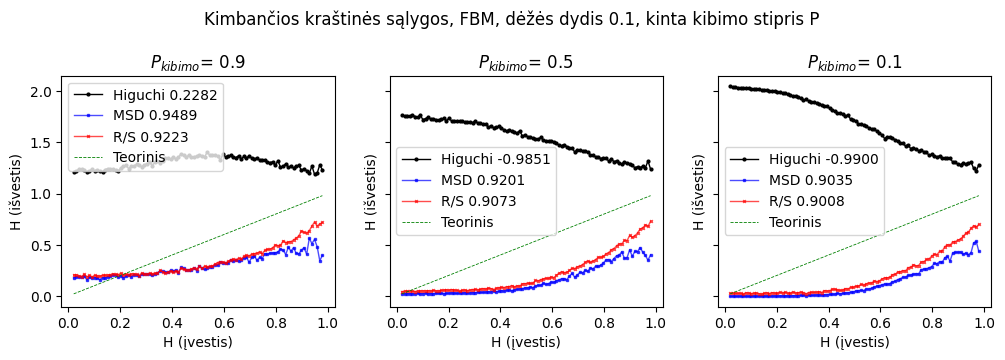

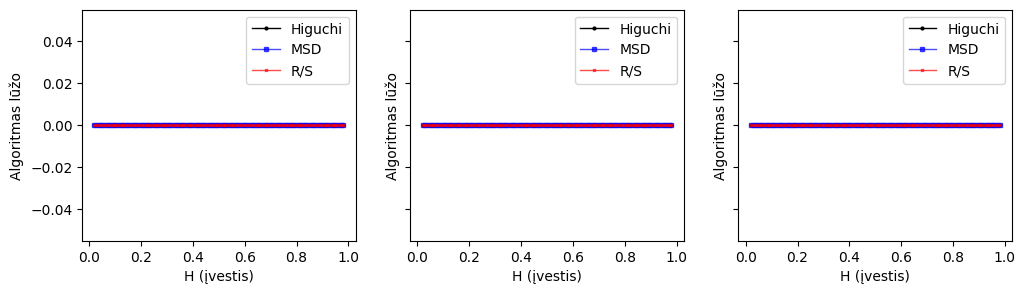

In [ ]:
#@title plot kimbanti dėžės for fbm

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, P_kibimo in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3], [0.9,0.5,0.1])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_kimbantis, box_size =0.1,title=r'$P_{kibimo}$= '+f'{P_kibimo}', N =1000, K = 10, H_N = 100, P_kibimo = P_kibimo)
fig.suptitle('Kimbančios kraštinės sąlygos, FBM, dėžės dydis 0.1, kinta kibimo stipris P',y=1.1)

3it [05:36, 112.17s/it]
3it [05:36, 112.03s/it]
3it [05:34, 111.50s/it]


Text(0.5, 0.98, 'Kimbančios kraštinės sąlygos, FBM, kinta kibimo stipris P ir dėžės dydis')

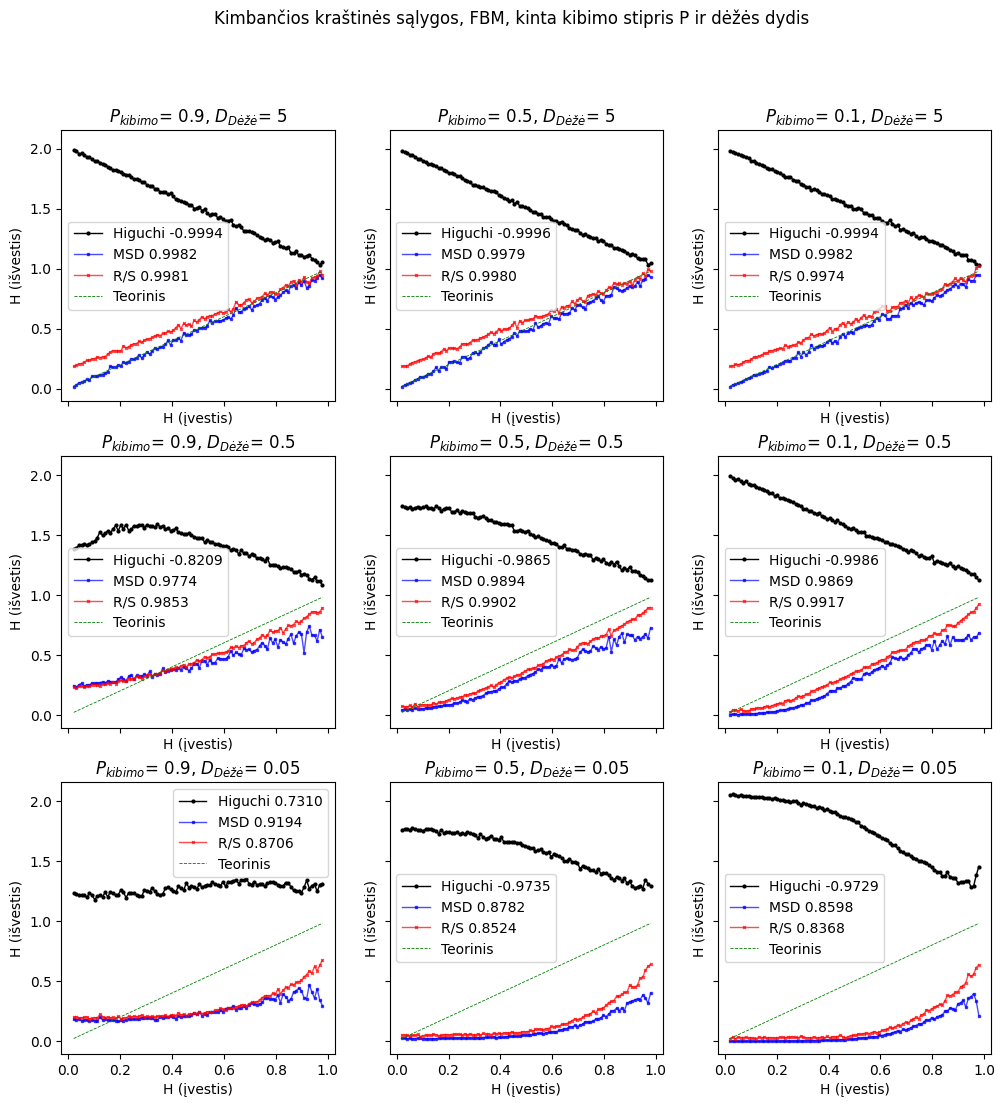

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,3, figsize=(12,12), sharey = True, sharex=True)


for ax, box_size in zip([ax1,ax2,ax3],[5,0.5,0.05]):

    for P_kibimo,i in wait(zip([0.9,0.5,0.1], [0,1,2])):

        FBM_hurst(ax[i],bx, krastine_salyga=judesys_dezeje_kimbantis, box_size =box_size,title=r'$P_{kibimo}$= '+f'{P_kibimo}, ' +r'$D_{Dėžė}$= '+f'{box_size}', N =1000, K = 10, H_N = 100, P_kibimo = P_kibimo)

fig.suptitle('Kimbančios kraštinės sąlygos, FBM, kinta kibimo stipris P ir dėžės dydis')

3it [05:36, 112.23s/it]
3it [05:36, 112.26s/it]
3it [05:38, 112.87s/it]


Text(0.5, 0.98, 'Kimbančios kraštinės sąlygos, FBM, kinta kibimo stipris P ir dėžės dydis')

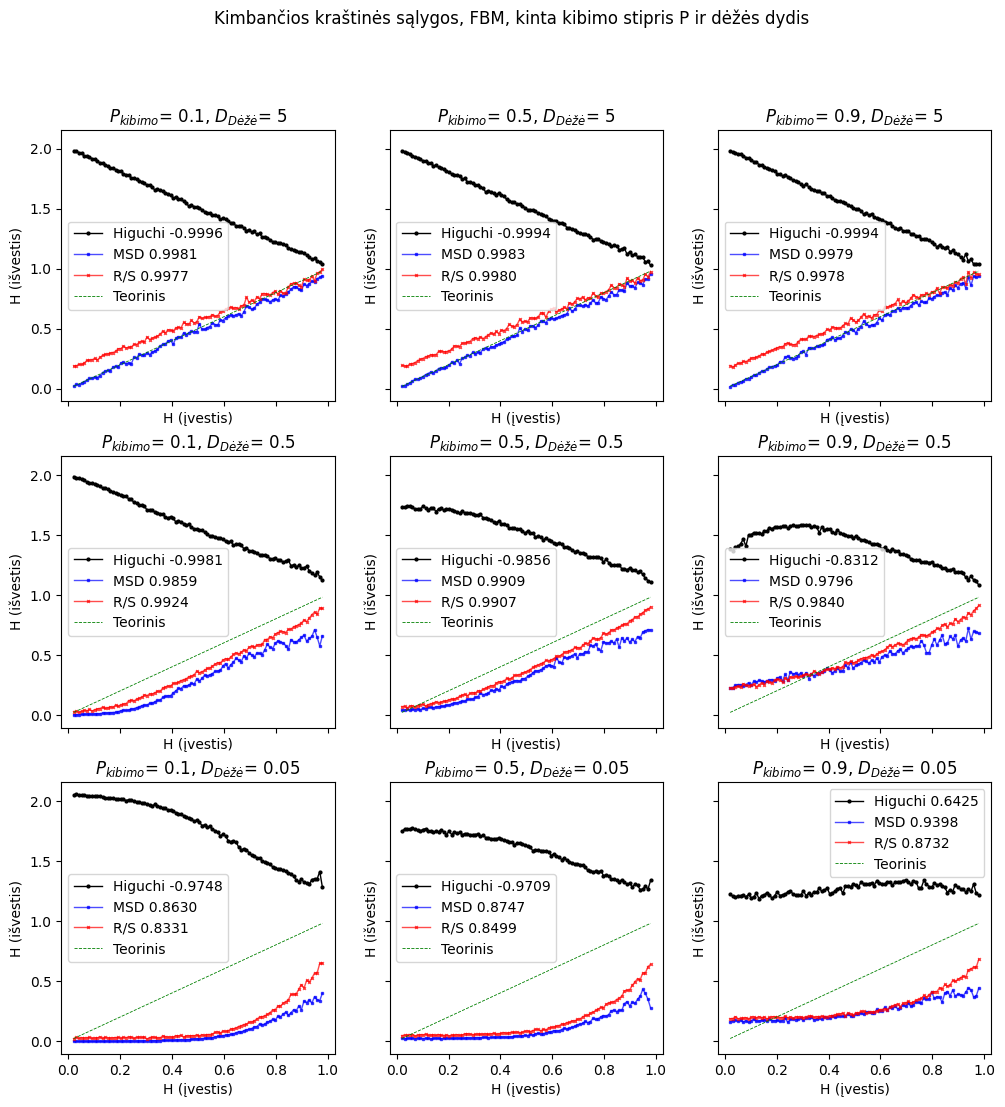

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,3, figsize=(12,12), sharey = True, sharex=True)


for ax, box_size in zip([ax1,ax2,ax3],[5,0.5,0.05]):

    for P_kibimo,i in wait(zip([0.1,0.5,0.9], [0,1,2])):

        FBM_hurst(ax[i],bx, krastine_salyga=judesys_dezeje_kimbantis, box_size =box_size,title=r'$P_{kibimo}$= '+f'{P_kibimo}, ' +r'$D_{Dėžė}$= '+f'{box_size}', N =1000, K = 10, H_N = 100, P_kibimo = P_kibimo)

fig.suptitle('Kimbančios kraštinės sąlygos, FBM, kinta kibimo stipris P ir dėžės dydis')

1it [01:52, 112.24s/it]<ipython-input-10-8ca816d04940>:17: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(Lk/(m+1)))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
2it [03:42, 111.20s/it]


Text(0.5, 1.1, 'Nukirptos kraštinės sąlygos')

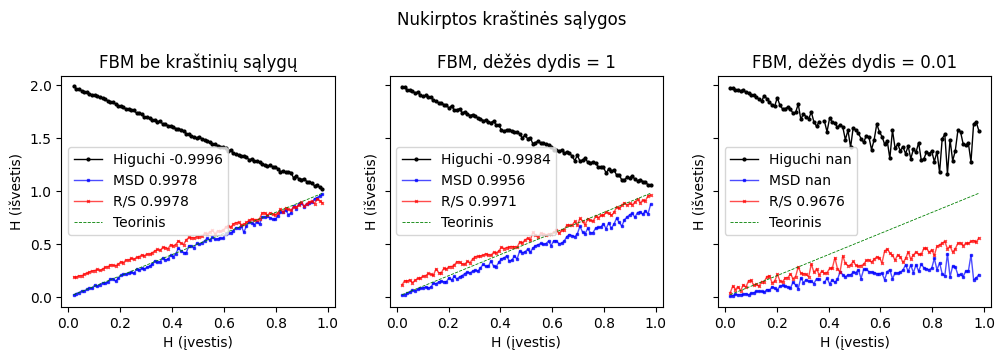

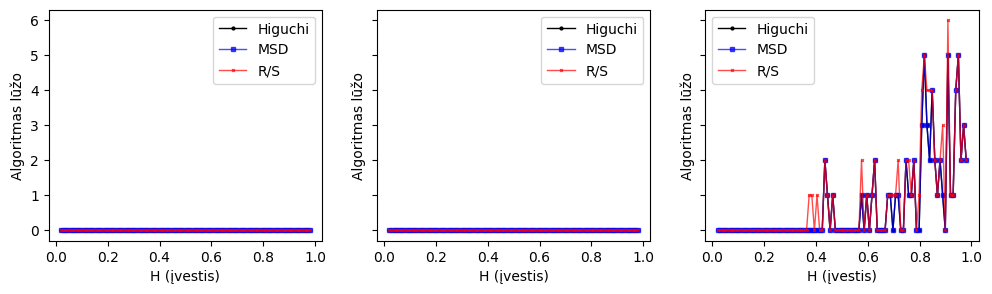

In [ ]:
#@title plot nukirptos dėžės for fbm
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


FBM_hurst(ax1,bx1, krastine_salyga=None)
for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [1,0.01])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus, box_size =box_size)
#ax1.legend(loc='lower right')
fig.suptitle('Nukirptos kraštinės sąlygos',y=1.1)


2it [04:23, 131.72s/it]


Text(0.5, 1.06, 'Tamprios kraštinės sąlygos')

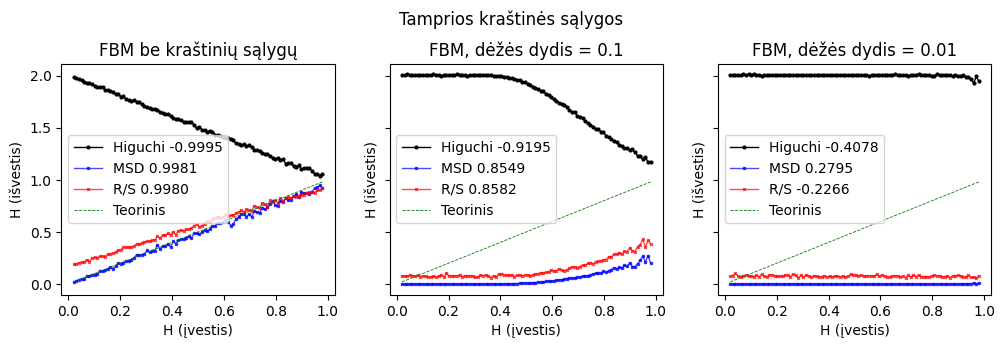

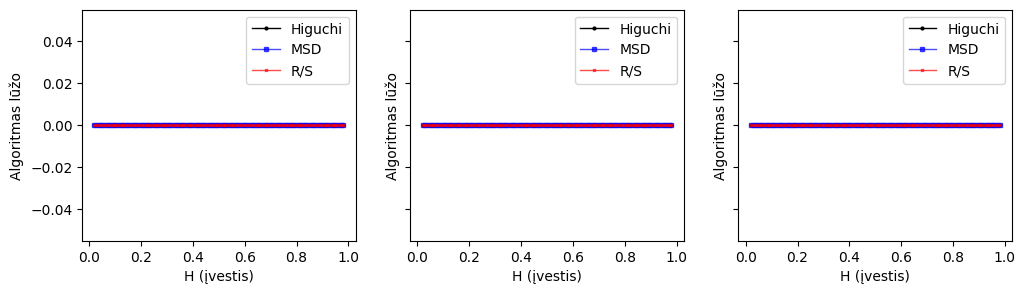

In [ ]:
#@title plot tamprus dėžės for fbm
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)

fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)

FBM_hurst(ax1,bx1, krastine_salyga=None)
for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [0.1,0.01])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_tamprus, box_size =box_size)
#ax1.legend(loc='lower right')
fig.suptitle('Tamprios kraštinės sąlygos',y=1.06)

In [ ]:
#@title plot for levy
from scipy.stats import levy_stable



def levy_hurst(ax, bx, beta=-1, krastine_salyga = judesys_dezeje_netamprus,title= None,N =1000,K=10,H_N =100, **kwargs):
    hh_higuchi =[]
    hh_msd =[]
    hh_rs = []

    FAILED_higuchi = []
    FAILED_msd =[]
    FAILED_rs =[]


    hh  = np.linspace(0.51,1, H_N)[2:-2]

    for h in hh:

        #f = FBM(n=N, hurst=h, length=10, method='daviesharte')
        #paimam vidurki aritmetini kad grafikai nesokinetu tiek
        K = K
        K_higuchi = K
        K_msd = K
        K_rs = K
        higuchi =0
        msd = 0
        rs = 0



        for _ in range(K):

            try:
                xx0 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()/1000
                if krastine_salyga != None:
                    try:
                        xx = krastine_salyga(xx0,**kwargs)
                    except:
                        print('kraštinė sąlyga dont work')
                else:
                    xx = xx0
            except:
                print('notgenerating')
                return



            try:
                higuchi += 2-higuchi1(xx)
            except:
                K_higuchi -=1
                if K_higuchi <=0:
                    print("fuck higuchi")

            try:
                msd += myMSD(xx)
            except:
                K_msd -=1
                if K_msd <=0:
                    print("fuck msd")
            try:
                rs += myRS(xx)
            except:
                K_rs -=1
                if K_rs <=0:
                    print("fuck rs")

        FAILED_higuchi.append(K-K_higuchi)
        FAILED_msd.append(K-K_msd)
        FAILED_rs.append(K-K_rs)

        hh_higuchi.append( higuchi/K_higuchi )
        hh_msd.append(msd/K_msd)
        hh_rs.append(rs/K_rs)

    if title != None:
        ax.set_title(title)
    else:
        if krastine_salyga!=None:
            ax.set_title(f'Dėžės dydis = {box_size}')
        else:
            ax.set_title(f'Be kraštinių sąlygų')



    R_higuchi = np.corrcoef(hh, hh_higuchi)[0,1];
    R_msd = np.corrcoef(hh, hh_msd)[0,1];
    R_rs = np.corrcoef(hh, hh_rs)[0,1];

    ax.plot(hh,hh_higuchi, label=r'Higuchi'+f' {R_higuchi:0.4f}', color='black', marker='o',linewidth = 1, markersize =2)
    ax.plot(hh,hh_msd, label = 'MSD'+f' {R_msd:0.4f}', color='blue', alpha = 0.7,marker='s',linewidth = 1, markersize =2)
    ax.plot(hh,hh_rs, label = 'R/S'+f' {R_rs:0.4f}', color='red', alpha = 0.7,marker='x',linewidth = 1, markersize =2)
    ax.plot(hh,hh, label='Teorinis', color='green', linewidth=0.6, linestyle ='--')

    ax.set_xlabel(r'H (įvestis)')
    ax.set_ylabel(r'H (išvestis)')

    ax.set_xlabel(r'H (įvestis)')
    ax.set_ylabel(r'H (išvestis)')
    ax.legend()

    try:
        bx.plot(hh, FAILED_higuchi, label=r'$2-D_{higuchi}$', color='black', marker='o',linewidth = 1, markersize =2)
        bx.plot(hh, FAILED_msd, label = 'MSD', color='blue', alpha = 0.7,marker='s',linewidth = 1, markersize =3)
        bx.plot(hh, FAILED_rs, label = 'R/S', color='red', alpha = 0.7,marker='x',linewidth = 1, markersize =2)
        bx.set_xlabel(r'H (įvestis)')
        bx.set_ylabel(r'Algoritmas lūžo')
        bx.legend()
    except:
        print('fuckity')

#fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)

#fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)

#fig.suptitle('Netamprios kraštinės sąlygos', y =1.07)

#levy_hurst(ax1,bx1, krastine_salyga=None)
#for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [1,0.01])):
#    levy_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus, box_size =box_size)
#ax1.legend(loc='lower left')


3it [00:48, 16.17s/it]


Text(0.5, 1.1, 'Netamprios kraštinės sąlygos, Levy $\\alpha$-stabilus')

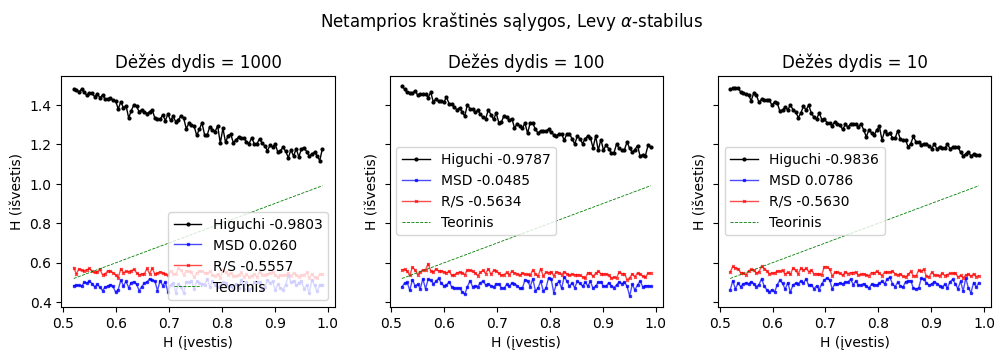

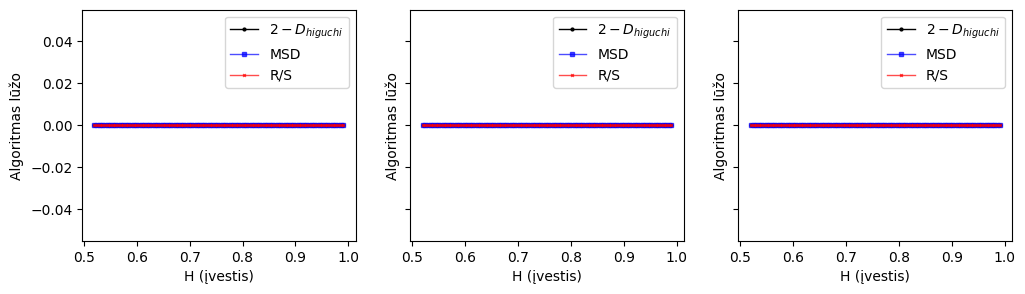

In [ ]:
#@title plot netamprus begantis dėžės for levy

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, box_size in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3], [1000,100,10])):
    levy_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus_begantis, box_size =box_size, N =1000, K = 10, H_N = 100)
ax1.legend(loc='lower right')
fig.suptitle(r'Netamprios kraštinės sąlygos, Levy $\alpha$-stabilus',y=1.1)

3it [00:48, 16.18s/it]


Text(0.5, 1.1, 'Netamprios kraštinės sąlygos,  Levy $\\alpha$-stabilus')

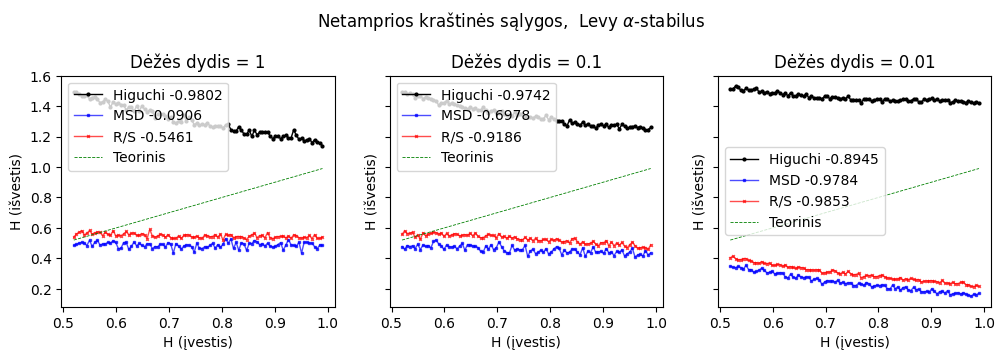

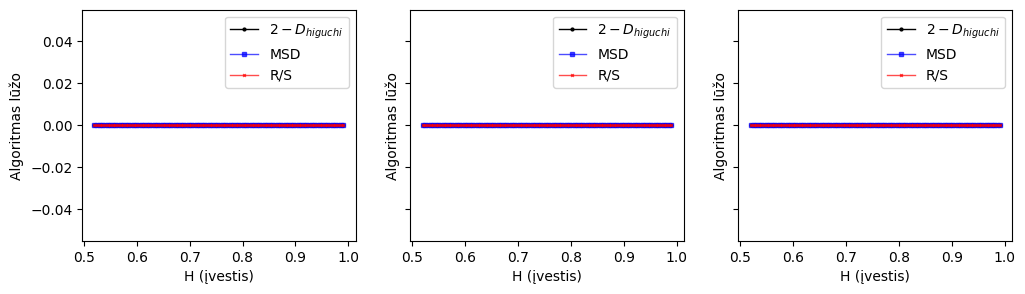

In [ ]:
#@title plot netamprus begantis dėžės for levy

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, box_size in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3], [1,0.1,0.01])):
    levy_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus_begantis, box_size =box_size, N =1000, K = 10, H_N = 100)
ax1.legend(loc='upper left')
fig.suptitle(r'Netamprios kraštinės sąlygos,  Levy $\alpha$-stabilus',y=1.1)

2it [00:32, 16.13s/it]


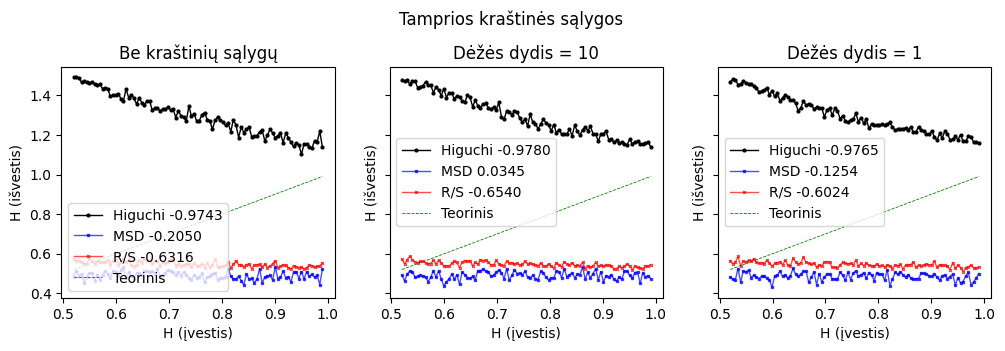

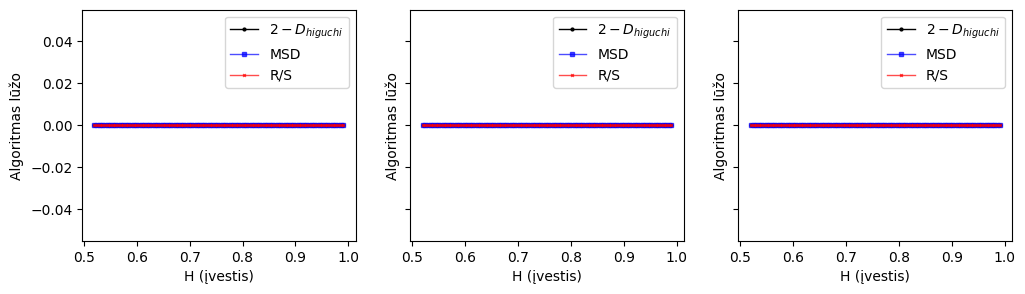

In [ ]:
#@title plot tampri dėžės for levy
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)

fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)
fig.suptitle('Tamprios kraštinės sąlygos', y =1.07)

levy_hurst(ax1,bx1, krastine_salyga=None)
for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [10,1])):
    levy_hurst(ax,bx, krastine_salyga=judesys_dezeje_tamprus,N =1000, box_size =box_size)
ax1.legend(loc='lower left')

3it [00:49, 16.39s/it]


Text(0.5, 1.1, 'Kimbančios kraštinės sąlygos')

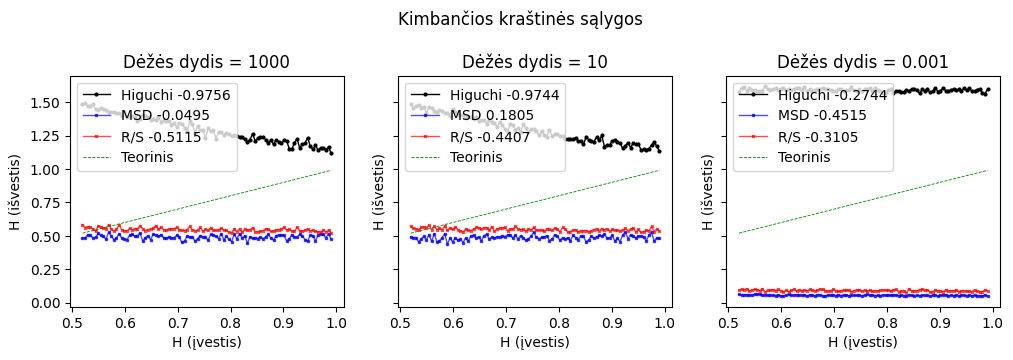

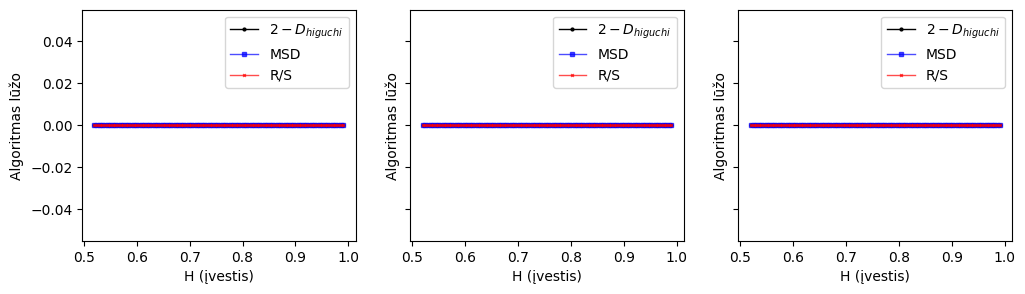

In [ ]:
#@title plot kimbanti dėžės for levy

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, box_size in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3], [1000,10,0.001])):
    levy_hurst(ax,bx, krastine_salyga=judesys_dezeje_kimbantis, box_size =box_size, P_kibimo=0.5, N =1000, K = 10, H_N = 100)
fig.suptitle('Kimbančios kraštinės sąlygos',y=1.1)

3it [00:49, 16.42s/it]
3it [00:49, 16.39s/it]
3it [00:49, 16.45s/it]


Text(0.5, 0.98, 'Kimbančios kraštinės sąlygos, Levy, kinta kibimo stipris P ir dėžės dydis')

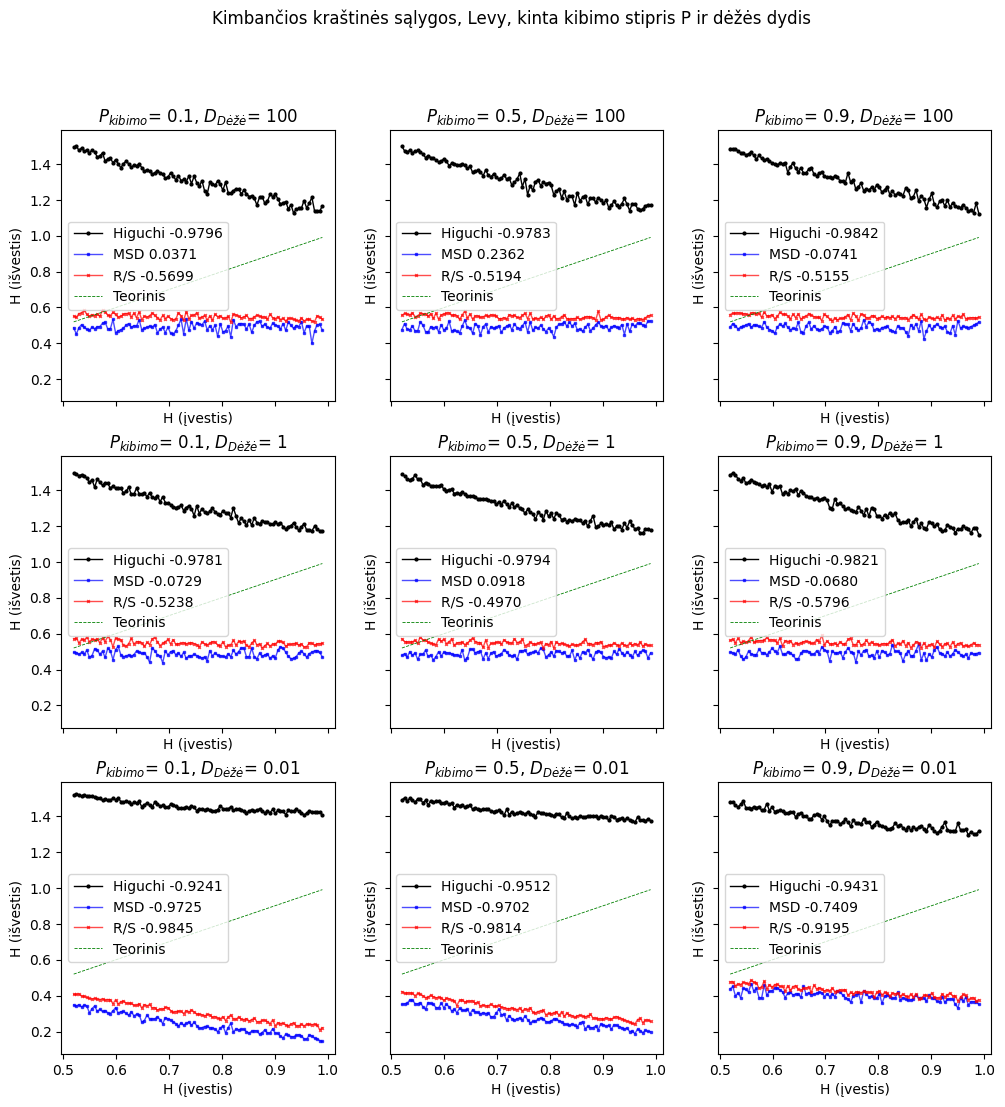

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,3, figsize=(12,12), sharey = True, sharex=True)

0
for ax, box_size in zip([ax1,ax2,ax3],[100,1,0.01]):

    for P_kibimo,i in wait(zip([0.1,0.5,0.9], [0,1,2])):
        try:
            levy_hurst(ax[i],bx, krastine_salyga=judesys_dezeje_kimbantis, box_size =box_size,title=r'$P_{kibimo}$= '+f'{P_kibimo}, ' +r'$D_{Dėžė}$= '+f'{box_size}', N =1000, K = 10, H_N = 100, P_kibimo = P_kibimo)
        except:
            pass
fig.suptitle('Kimbančios kraštinės sąlygos, Levy, kinta kibimo stipris P ir dėžės dydis')

In [ ]:
#@title plot kimbanti dėžės for fbm

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)
fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


for ax,bx, P_kibimo in wait(zip([ax1,ax2,ax3],[bx1, bx2,bx3],[0.1,0.5,0.9])):
    levy_hurst(ax,bx, krastine_salyga=judesys_dezeje_kimbantis, box_size =0.1,title=r'$P_{kibimo}$= '+f'{P_kibimo}', N =1000, K = 10, H_N = 100, P_kibimo = P_kibimo)
fig.suptitle('Kimbančios kraštinės sąlygos, Levy, dėžės dydis 0.1, kinta kibimo stipris P',y=1.1)

# Levy fbm vizualizacijos


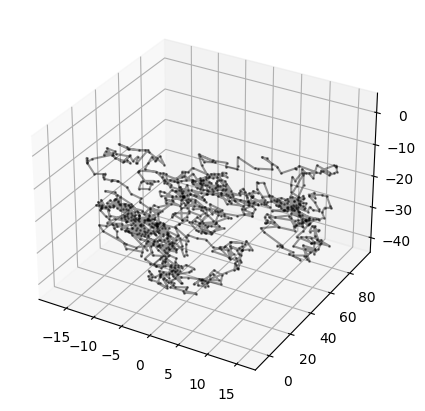

In [ ]:
h = 0.5
N = 1000

xx0 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()
xx1 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()
xx2 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(xx0,xx1,xx2, alpha = 0.4, color='black',marker='o', markersize=1)

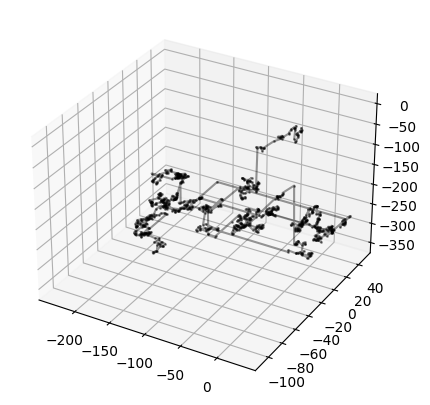

In [ ]:
h = 0.7
N = 1000

xx0 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()
xx1 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()
xx2 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(xx0,xx1,xx2, alpha = 0.4, color='black',marker='o', markersize=1)

<Figure size 500x500 with 0 Axes>

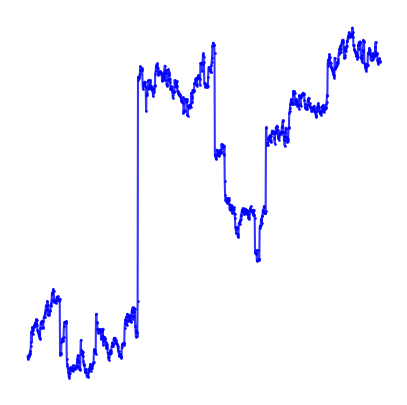

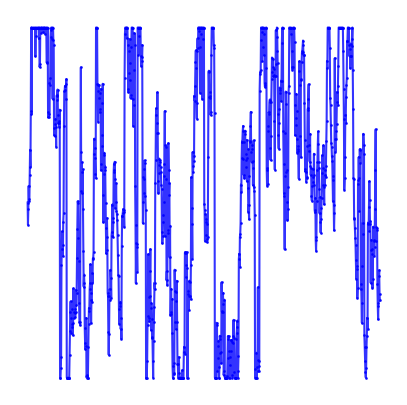

<Figure size 500x500 with 0 Axes>

In [ ]:
h = 0.7
N = 1000

xx0 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()

#ax = plt.figure().add_subplot(projection='3d')
plt.plot(xx0, alpha = 0.8, color='blue',marker='o', markersize=1)
plt.axis('off')
plt.figure()

xx = judesys_dezeje_kimbantis(xx0, box_size = 10)

plt.plot(xx, alpha = 0.8, color='blue',marker='o', markersize=1)
plt.axis('off')
plt.figure()



<Figure size 500x500 with 0 Axes>

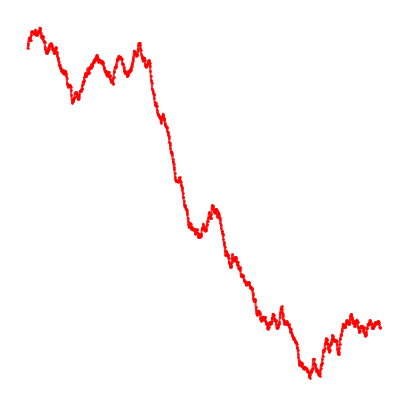

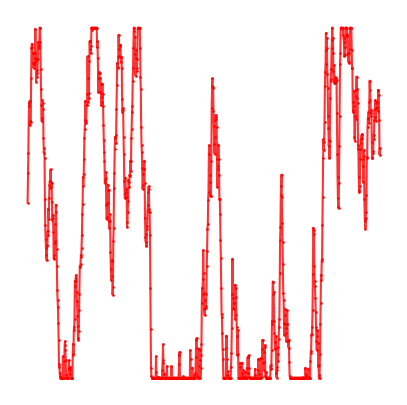

<Figure size 500x500 with 0 Axes>

In [ ]:
h = 0.7
N = 1000

#xx0 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()

f = FBM(n=N, hurst=h, length=1000, method='daviesharte')

xx0 = f.fbm()[1:]



#ax = plt.figure().add_subplot(projection='3d')
plt.plot(xx0, alpha = 0.8, color='red',marker='o', markersize=1)
plt.axis('off')
plt.figure()

xx = judesys_dezeje_kimbantis(xx0, box_size = 10)

plt.plot(xx, alpha = 0.8, color='red',marker='o', markersize=1)
plt.axis('off')
plt.figure()


(-49.95, 1048.95, -2765.9024165413553, 1613.1404475875765)

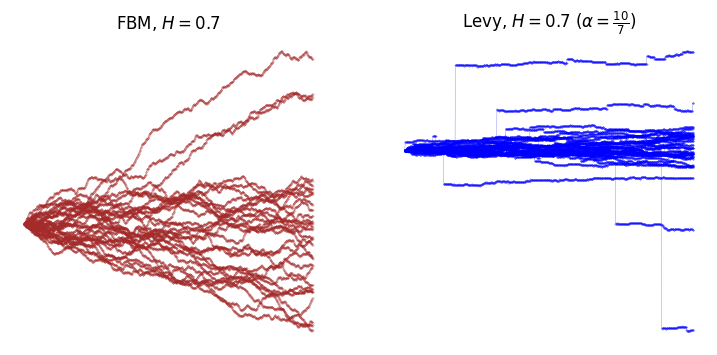

In [ ]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(9,4))#, sharey = True, sharex=True)

#fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)


h = 0.7
N = 1000
K = 30


f = FBM(n=N, hurst=h, length=100, method='daviesharte')
for _ in range(K):
    xx1 = f.fbm()[1:]
    ax1.plot(xx1, alpha = 0.5, color='brown',marker='o', markersize=0.3, linewidth=0.3)


ax1.set_title('FBM, $H =0.7$')
ax1.set_ylabel(r'$X_t$')
ax1.set_xlabel('$t$')
ax1.axis('off')

for _ in range(K):
    xx2 = levy_stable.rvs(alpha=1/h, beta=0, size=N).cumsum()
    #ax = plt.figure().add_subplot(projection='3d')
    ax2.plot(xx2, alpha = 0.5, color='blue',marker='o', markersize=0.3,linewidth=0.3)

ax2.set_title(r'Levy, $H =0.7$ ($\alpha = \frac{10}{7}$)')

ax2.set_ylabel(r'$L_t$')
ax2.set_xlabel('$t$')
ax2.axis('off')




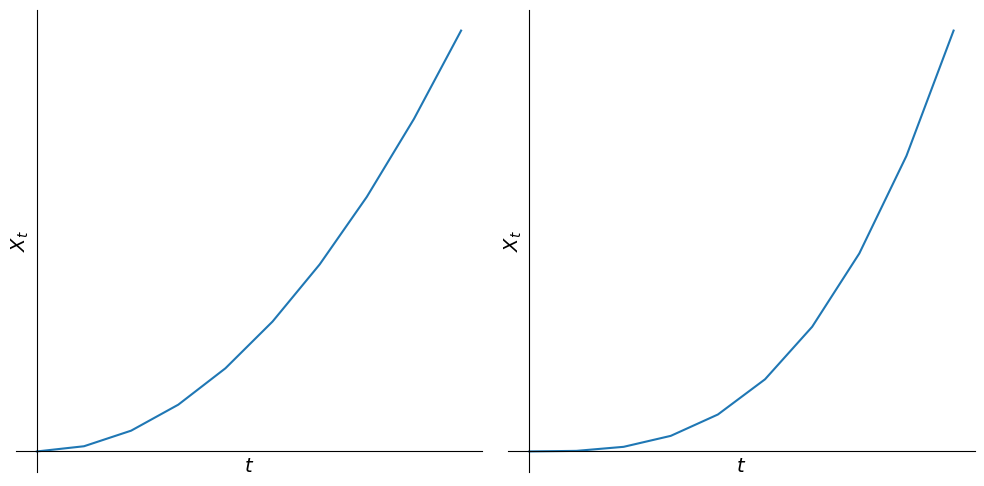

In [ ]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plotting some example data
t = range(10)
X_t1 = [x**2 for x in t]
X_t2 = [x**3 for x in t]

# Plot on the first subplot
ax1.plot(t, X_t1)
ax1.set_xlabel('$t$', fontsize=14)
ax1.set_ylabel('$X_t$', fontsize=14)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_position('zero')
ax1.spines['left'].set_position('zero')
ax1.yaxis.set_ticks([])
ax1.xaxis.set_ticks([])

# Plot on the second subplot
ax2.plot(t, X_t2)
ax2.set_xlabel('$t$', fontsize=14)
ax2.set_ylabel('$X_t$', fontsize=14)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_position('zero')
ax2.spines['left'].set_position('zero')
ax2.yaxis.set_ticks([])
ax2.xaxis.set_ticks([])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# patikrinkim kad kodai tikrai veiktų kuriuos į priedą dedu



In [ ]:
def netampri_krastine_salyga_v1(realizacija, d):
    realizacija_dezeje = [] #d := dezes dydis
    for X in realizacija:
        if   X >  d:
            X  =  d
        elif X < -d:
            X  = -d
        realizacija_dezeje.append(X)
    return np.array(realizacija_dezeje)

def tampri_krastine_salyga(realizacija, d=1):

    realizacija_dezeje = np.zeros_like(realizacija)
    position = 0

    for i, position in enumerate(realizacija):
        # Reflect if the position goes outside the boundary nu sita gera yra!
        while abs(position) > box_size:
            if position > d:
                overshoot = position - d
                position = d - overshoot
            elif position < -d:
                overshoot = -d - position
                position = -d + overshoot

        realizacija_dezeje[i] = position

    return realizacija_dezeje


def netampri_krastine_salyga_v2(realizacija, d):
    realizacija_dezeje = []
    X = 0
    realizacija_dezeje.append(X)
    dXX = realizacija[1:]-realizacija[:-1]  #gaunam prieaugius
    for dX in dXX:
        #po viena priaugi pridedam
        X += dX
        #jei lipa X virs dezes -- neleidziame
        if   X > d:
            X =  d
        elif X <-d:
            X = -d
        realizacija_dezeje.append(X)
    return np.array(realizacija_dezeje)


def kimbanti_krastine_salyga(realizacija, d, P_kibimo =0.5):
    realizacija_dezeje = []
    X = 0
    realizacija_dezeje.append(X)
    dXX = realizacija[1:]-realizacija[:-1] #dXX prieaugiai
    for dX in dXX:
        if abs(X) == d: #jei prie sienos prikibes
            #mesk kauliuka ar atlipsi
            if np.random.random()>P_kibimo:
                X += dX
        else: #jei prie sienos neprikibes
            X += dX
        #dezes prasokti negalima
        if   X >  d:
            X = d
        elif X < -d:
            X = -d
        realizacija_dezeje.append(X)
    return np.array(realizacija_dezeje) #grazinam realizacija

krastines_salygos = [netampri_krastine_salyga_v1,
                    netampri_krastine_salyga_v2,
                    tampri_krastine_salyga,
                    kimbanti_krastine_salyga]


In [ ]:
def hurstai(xx):
    try:
        higuchi = 2-higuchi1(xx)
    except:
        print("fuck higuchi")
        higuchi='error'
    try:
        msd = myMSD(xx)
    except:
        print("fuck msd")
        msd = 'error'
    try:
        rs = myRS(xx)
    except:
        print("fuck rs")
        rs = 'error'

    return higuchi, msd, rs

In [ ]:

def plotKrastines(H =0.7):
    f = FBM(n=1000, hurst=H, length=10, method='daviesharte')

    d = 1

    fig, [ax0,ax1, ax2,ax3,ax4] = plt.subplots(1,5, figsize=(15,3), sharey = True, sharex=True)

    axes = [ax0,ax1,ax2,ax3,ax4]



    xx0 = f.fbm()
    ax0.set_title(f'Be kraštinių sąlygų FBM su H={H}')


    xx1 = netampri_krastine_salyga_v1(xx0, d = d)
    ax1.set_title('Netampri kraštinė sąlyga (v1)')


    xx2 = netampri_krastine_salyga_v2(xx0, d = d)
    ax2.set_title('Netampri kraštinė sąlyga (v2)')


    xx3 = tampri_krastine_salyga(xx0, d = d)
    ax3.set_title('Tampri kraštinė sąlyga')

    xx4 = kimbanti_krastine_salyga(xx0, d = d, P_kibimo =0.7)
    ax4.set_title('Kimbanti kraštinė sąlyga P=0.7')


    xxx = [xx0,xx1,xx2,xx3,xx4]

    for ax,xx in zip(axes,xxx):
        ax.axhline(y=box_size, linestyle='--',color='red')
        ax.axhline(y=-box_size, linestyle='--',color='red')
        higuchi, msd, rs = hurstai(xx)
        ax.plot(xx,color='black',\
            label = r'$H_{Higuchi}=$'+f'{higuchi:1.2f}'\
            +'\n'+'$H_{MSD}=$'+f'{msd:1.2f}'\
            +'\n'+'$H_{RS}=$'+f'{rs:1.2f}')

        ax.legend(fontsize=13)

    fig.tight_layout()

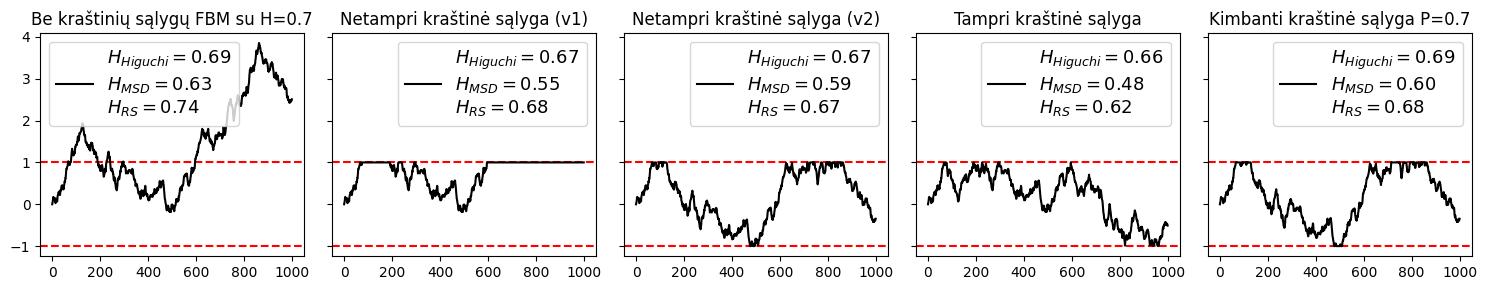

In [ ]:
plotKrastines(H =0.7)

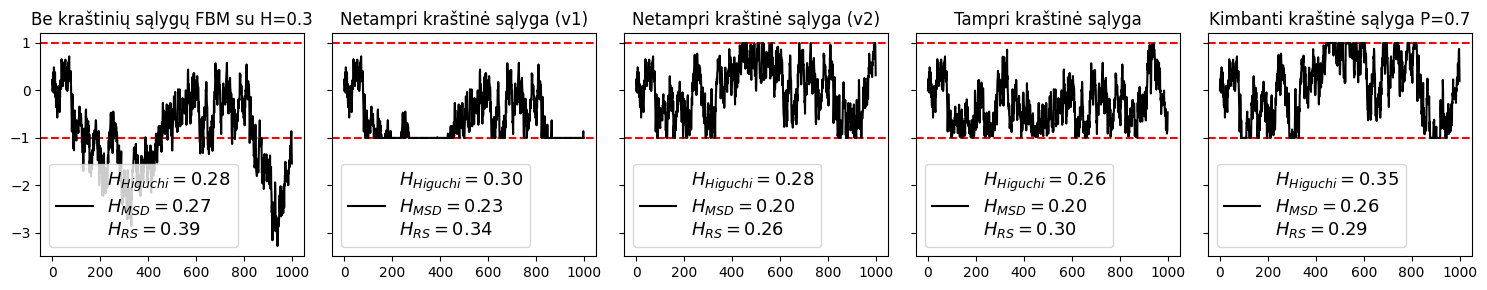

In [ ]:
plotKrastines(H =0.3)

In [ ]:
def plotKrastinesLevy():

    d = 1

    fig, [ax0,ax1, ax2,ax3,ax4] = plt.subplots(1,5, figsize=(15,3), sharey = True, sharex=True)

    axes = [ax0,ax1,ax2,ax3,ax4]



    xx0 = levy_stable.rvs(alpha=4/3, beta=0, size=1000).cumsum()/40
    ax0.set_title(r'Be kraštinių sąlygų Levy su $\alpha=4/3$')


    xx1 = netampri_krastine_salyga_v1(xx0, d = d)
    ax1.set_title('Netampri kraštinė sąlyga (v1)')


    xx2 = netampri_krastine_salyga_v2(xx0, d = d)
    ax2.set_title('Netampri kraštinė sąlyga (v2)')


    xx3 = tampri_krastine_salyga(xx0, d = d)
    ax3.set_title('Tampri kraštinė sąlyga')

    xx4 = kimbanti_krastine_salyga(xx0, d = d, P_kibimo =0.7)
    ax4.set_title('Kimbanti kraštinė sąlyga P=0.7')


    xxx = [xx0,xx1,xx2,xx3,xx4]

    for ax,xx in zip(axes,xxx):
        ax.axhline(y=box_size, linestyle='--',color='red')
        ax.axhline(y=-box_size, linestyle='--',color='red')
        higuchi, msd, rs = hurstai(xx)
        ax.plot(xx,color='black',\
            label = r'$H_{Higuchi}=$'+f'{higuchi:1.2f}'\
            +'\n'+'$H_{MSD}=$'+f'{msd:1.2f}'\
            +'\n'+'$H_{RS}=$'+f'{rs:1.2f}')

        ax.legend(fontsize=13)


    fig.tight_layout()

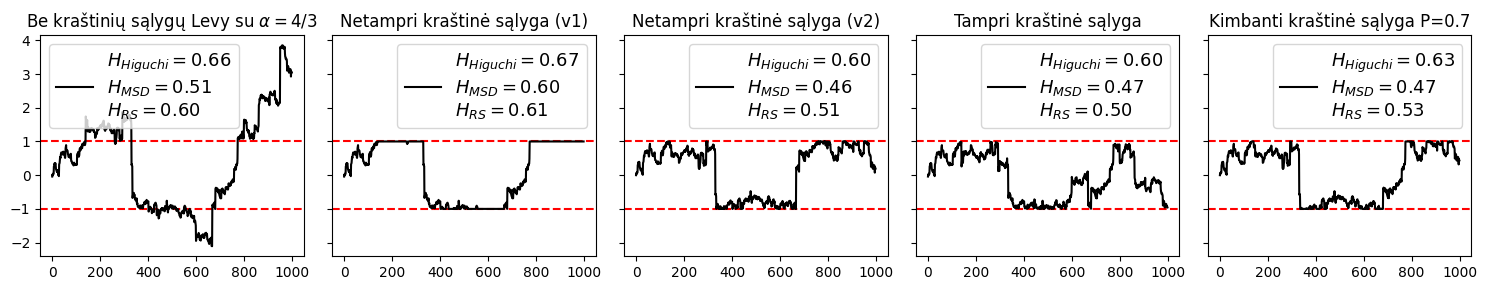

In [ ]:

plotKrastinesLevy()

In [ ]:
#

# wavelety


In [ ]:
# Example usage (commented out for now)

alpha = np.corrcoef(data_norm[0:-1], data_norm[1:])[0,1];
print("Lag-1 autocorrelation = {:4.2f}".format(alpha))
result = waipy.cwt(data_norm, 1, 1, 0.25, 2, 4/0.25, alpha, 6, mother='Morlet', name='penis')
waipy.wavelet_plot(f'dėžėje {box_size}', time, data_norm, 0.03125, result);

#noise_data = np.random.normal(0, 0.1, 1000)  # Generating some random noise
#result = #mirror_reflection_bounded_fbm(noise_data)
result = noise_data
# print(result)
data_norm = waipy.normalize(result)
label='sdf'
time = np.arange(0, 1000)

alpha = np.corrcoef(data_norm[0:-1], data_norm[1:])[0,1];
print("Lag-1 autocorrelation = {:4.2f}".format(alpha))
result = waipy.cwt(data_norm, 1, 1, 0.25, 2, 4/0.25, alpha, 6, mother='Morlet', name='penis')
waipy.wavelet_plot('laisvas', time, data_norm, 0.03125, result);

In [ ]:
1/1.25

0.8

In [ ]:
4/3

1.3333333333333333

In [ ]:
3/4

0.75

# *NORMUOJAM


/usr/local/lib/python3.10/dist-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
1it [01:56, 116.58s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
2it [03:50, 115.32s/it]


Text(0.5, 1.1, 'Netamprios kraštinės sąlygos')

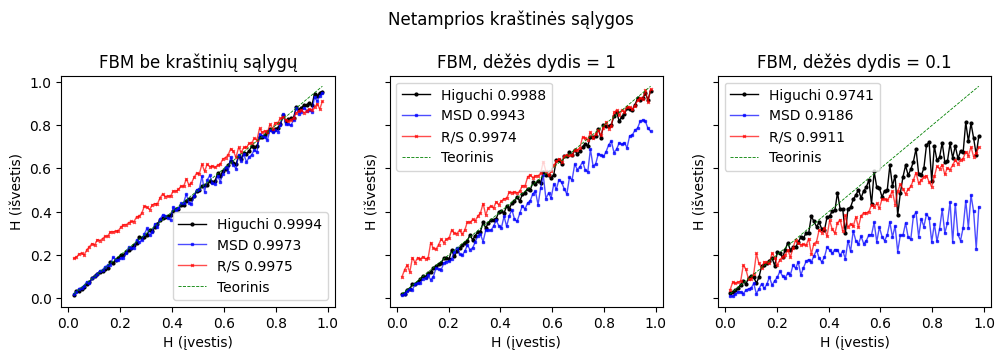

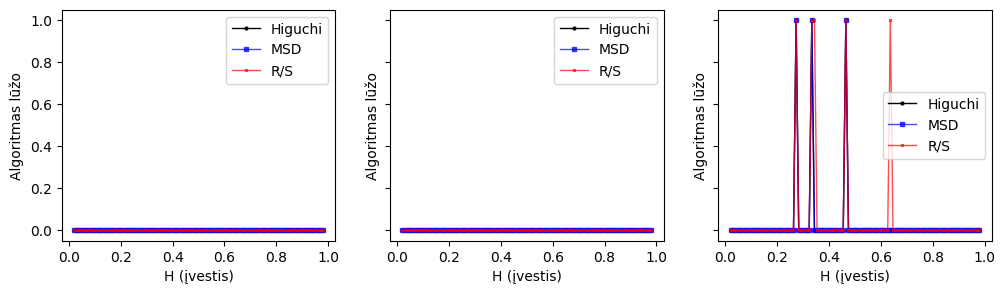

In [ ]:
#@title plot  fbm
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)

fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)



N = 1000


def FBM_hurst_normuota(ax, bx, beta=-1,  krastine_salyga = judesys_dezeje_netamprus,N = 1000, K =10,H_N = 100,title =None, **kwargs):
    hh_higuchi =[]
    hh_msd =[]
    hh_rs = []

    FAILED_higuchi = []
    FAILED_msd =[]
    FAILED_rs =[]


    hh  = np.linspace(0,1, H_N)[2:-2]

    for h in hh:
        #xx = levy_stable.rvs(alpha=a, beta=beta, size=N).cumsum()

        f = FBM(n=N, hurst=h, length=10, method='daviesharte')
        #paimam vidurki aritmetini kad grafikai nesokinetu tiek
        K_higuchi = K
        K_msd = K
        K_rs = K
        higuchi =0
        msd = 0
        rs = 0



        for _ in range(K):

            xx0 = f.fbm()[1:]
            xx0 = xx0/np.std(xx0)

            if krastine_salyga!=None:
                xx = krastine_salyga(xx0,**kwargs)
            else:
                xx = xx0
            try:
                higuchi += 2-higuchi1(xx)
            except:
                K_higuchi -=1
                if K_higuchi <=0:
                    print("fuck higuchi")

            try:
                msd += myMSD(xx)
            except:
                K_msd -=1
                if K_msd <=0:
                    print("fuck msd")
            try:
                rs += myRS(xx)
            except:
                K_rs -=1
                if K_rs <=0:
                    print("fuck rs")

        FAILED_higuchi.append(10-K_higuchi)
        FAILED_msd.append(10-K_msd)
        FAILED_rs.append(10-K_rs)

        hh_higuchi.append( higuchi/K_higuchi )
        hh_msd.append(msd/K_msd)
        hh_rs.append(rs/K_rs)

    if title != None:
        ax.set_title(title)
    else:
        if krastine_salyga!=None:
            ax.set_title(f'FBM, dėžės dydis = {box_size}')
        else:
            ax.set_title(f'FBM be kraštinių sąlygų')


    R_higuchi = np.corrcoef(hh, hh_higuchi)[0,1];
    R_msd = np.corrcoef(hh, hh_msd)[0,1];
    R_rs = np.corrcoef(hh, hh_rs)[0,1];

    ax.plot(hh,hh_higuchi, label=r'Higuchi'+f' {R_higuchi:0.4f}', color='black', marker='o',linewidth = 1, markersize =2)
    ax.plot(hh,hh_msd, label = 'MSD'+f' {R_msd:0.4f}', color='blue', alpha = 0.7,marker='s',linewidth = 1, markersize =2)
    ax.plot(hh,hh_rs, label = 'R/S'+f' {R_rs:0.4f}', color='red', alpha = 0.7,marker='x',linewidth = 1, markersize =2)
    ax.set_xlabel(r'H (įvestis)')
    ax.set_ylabel(r'H (išvestis)')
    ax.plot(hh,hh, label='Teorinis', color='green', linewidth=0.6, linestyle ='--')

    ax.legend()

    try:
        bx.plot(hh, FAILED_higuchi, label=r'Higuchi', color='black', marker='o',linewidth = 1, markersize =2)
        bx.plot(hh, FAILED_msd, label = 'MSD', color='blue', alpha = 0.7,marker='s',linewidth = 1, markersize =3)
        bx.plot(hh, FAILED_rs, label = 'R/S', color='red', alpha = 0.7,marker='x',linewidth = 1, markersize =2)
        bx.set_xlabel(r'H (įvestis)')
        bx.set_ylabel(r'Algoritmas lūžo')
        bx.legend()
    except:
        print('fuckity')

FBM_hurst(ax1,bx1, krastine_salyga=None)
for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [1,0.1])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_netamprus, box_size =box_size)
ax1.legend(loc='lower right')
fig.suptitle('Netamprios kraštinės sąlygos',y=1.1)


2it [03:50, 115.07s/it]


Text(0.5, 1.1, 'Netamprios kraštinės sąlygos')

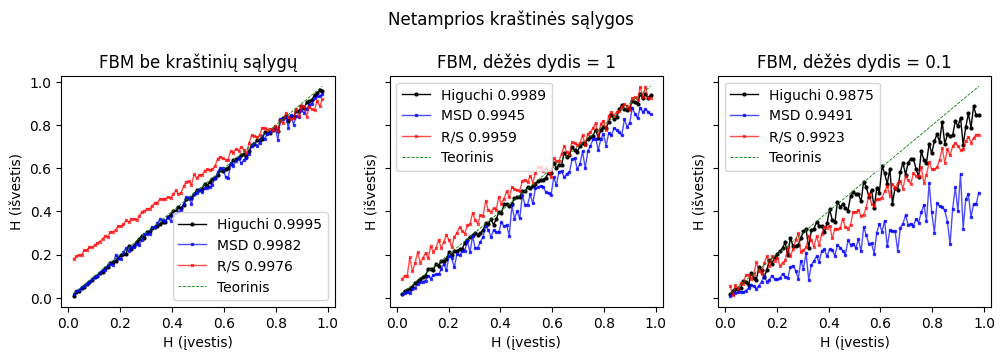

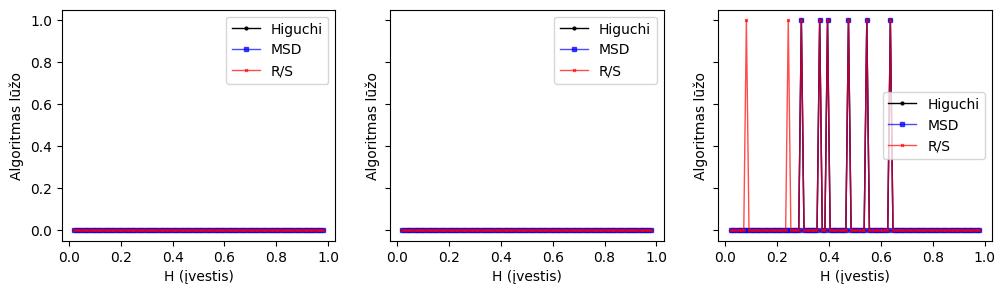

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)

fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)




FBM_hurst_normuota(ax1,bx1, krastine_salyga=None)
for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [1,0.1])):
    FBM_hurst_normuota(ax,bx, krastine_salyga=judesys_dezeje_netamprus, box_size =box_size)
ax1.legend(loc='lower right')
fig.suptitle('Netamprios kraštinės sąlygos',y=1.1)


In [ ]:
#@title plot tamprus dėžės for fbm
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)

fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)

FBM_hurst(ax1,bx1, krastine_salyga=None)
for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [0.1,0.01])):
    FBM_hurst(ax,bx, krastine_salyga=judesys_dezeje_tamprus, box_size =box_size)
#ax1.legend(loc='lower right')
fig.suptitle('Tamprios kraštinės sąlygos',y=1.06)

2it [03:48, 114.40s/it]


Text(0.5, 1.1, 'Netamprios kraštinės sąlygos')

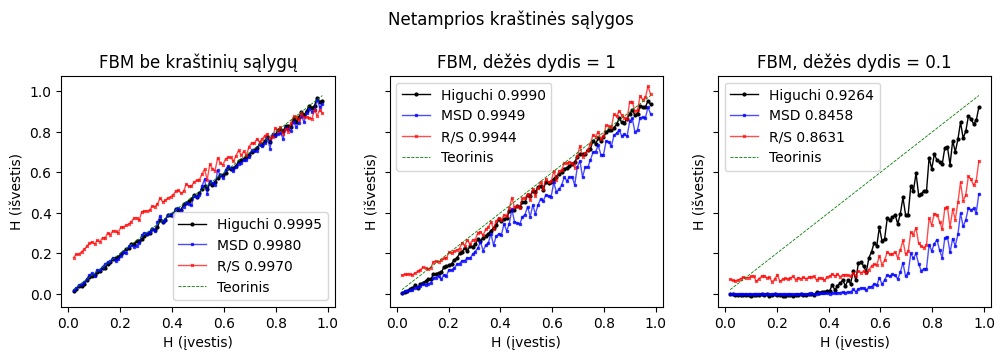

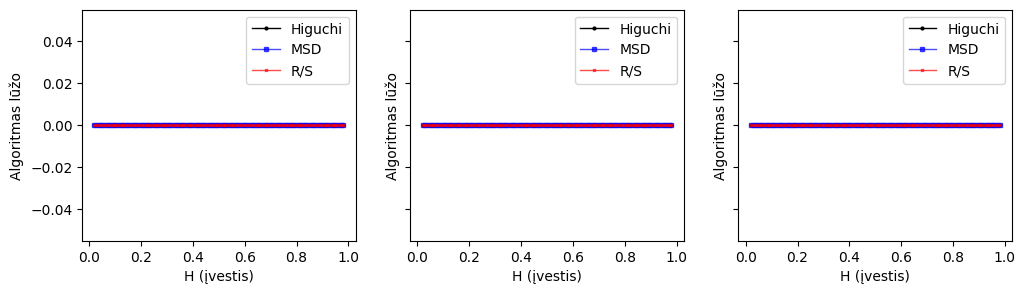

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,3), sharey = True, sharex=True)

fig2, [bx1,bx2,bx3] = plt.subplots(1,3, figsize=(12,3), sharey = True,sharex=True)




FBM_hurst_normuota(ax1,bx1, krastine_salyga=None)
for ax,bx, box_size in wait(zip([ax2,ax3],[bx2,bx3], [1,0.1])):
    FBM_hurst_normuota(ax,bx, krastine_salyga=judesys_dezeje_tamprus, box_size =box_size)
ax1.legend(loc='lower right')
fig.suptitle('Netamprios kraštinės sąlygos',y=1.1)

In [ ]:
def myMSD(series, plot = False):
    N = len(series)
    T = min(100, N // 2)  # You can adjust T depending on the series length
    tau_values = np.arange(1, T + 1)
    MSD = np.zeros(T)

    for i, tau in enumerate(tau_values):
        squared_displacements = (series[tau:] - series[:-tau]) ** 2
        MSD[i] = np.mean(squared_displacements)

    log_tau = np.log(tau_values)
    log_MSD = np.log(MSD)

    slope, intercept, r_value, p_value, std_err = linregress(log_tau, log_MSD)

    if plot:
        # Plotting the MSD curve
        plt.figure(figsize=(4, 3))
        plt.plot(log_tau, log_MSD, 'o', label='Log-Log MSD Data')
        plt.plot(log_tau, intercept + slope * log_tau, 'r', label=f'Fit line (slope = {slope:.2f})')
        plt.xlabel('Log(Tau)')
        plt.ylabel('Log(MSD)')
        plt.title('Log-Log Plot of Mean Squared Displacement')
        plt.legend()
        plt.grid(True)
        plt.show()

    return slope / 2  # Hurst exponent




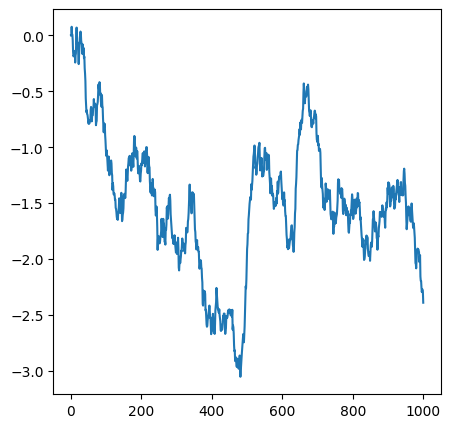

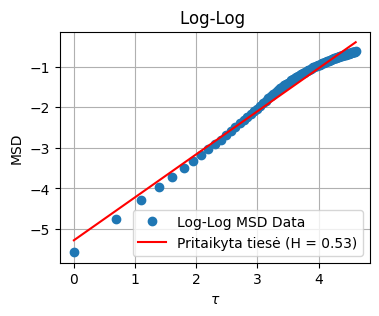

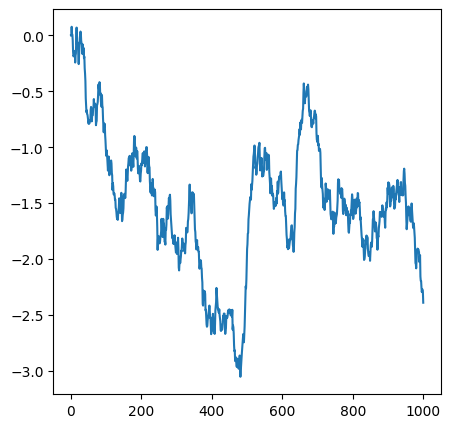

In [ ]:
f = FBM(n=1000, hurst=0.6, length = 10)
xx = f.fbm()
xx1 = judesys_dezeje_tamprus(xx, box_size = 1000)
plt.plot(xx1)


myMSD(xx1, plot=True)

plt.plot(xx)

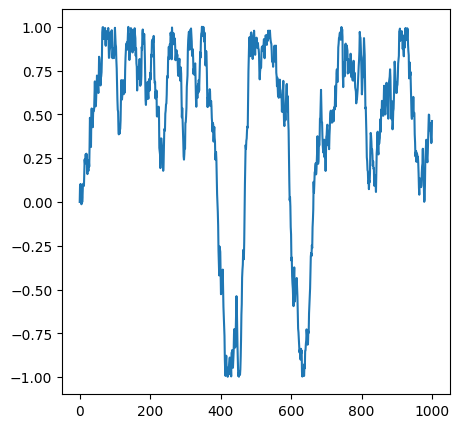

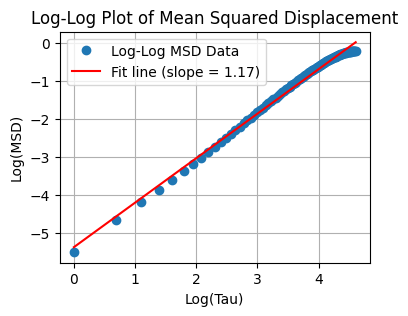

0.5835962377722654

Streaming output truncated to the last 5000 lines.
 5.09615788e-04 2.00270233e-03 1.08609451e-04 2.02033982e-04
 1.93175878e-02 1.33843436e-03 9.64945924e-04 2.46090455e-05
 5.89721076e-03 3.30157215e-04 1.86170682e-02 7.99289995e-03
 6.61006918e-04 1.38107647e-06 1.30097685e-02 1.67603955e-02
 2.61903941e-03 1.98063048e-02 1.80727943e-02 7.61757000e-03
 1.19107963e-02 2.77139247e-02 1.08597624e-02 6.15923119e-03
 3.08304438e-03 4.83747672e-04 7.23472270e-04 3.88983416e-04
 1.22497951e-02 5.96527676e-03 1.29196591e-02 2.38538684e-02
 9.76925129e-03 1.37527318e-02 1.74465153e-02 1.19471299e-02
 1.68957587e-04 2.85711211e-03 8.39753460e-03 5.75909864e-03
 4.36510847e-04 2.41844242e-02 4.76096135e-03 5.10885929e-05
 8.60253499e-03 2.96335233e-03 6.64807055e-05 4.86911506e-04
 1.06069939e-03 6.29047151e-03 3.85528054e-03 2.17701708e-03
 4.08034456e-03 3.05431384e-02 2.48812909e-03 1.09994020e-02
 2.50106027e-03 3.05899018e-03 3.69773372e-04 7.37663652e-03
 2.33707880e-03 7.71052659e-04 1.8

0.035891093132445116

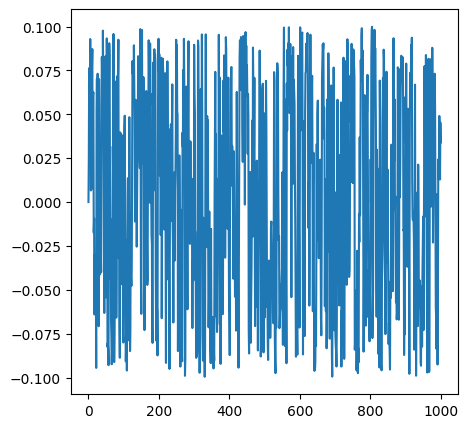

In [ ]:
f = FBM(n=1000, hurst=0.6, length = 10)
xx = f.fbm()
xx1 = judesys_dezeje_tamprus(xx, box_size = 0.1)
plt.plot(xx1)
myMSD(xx1, plot=True)

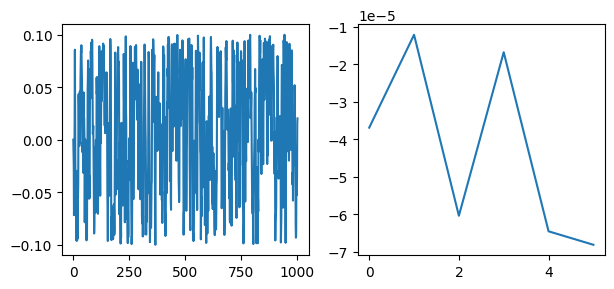

0.05291088212084023

In [ ]:
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(7,3))

f = FBM(n=1000, hurst=0.7, length = 10)
xx = f.fbm()
xx1 = judesys_dezeje_tamprus(xx, box_size = 0.1)
ax1.plot(xx1)
msd, h = myMSD(xx1, ax = ax2);
h

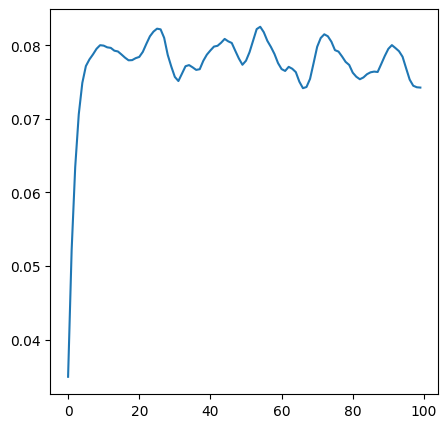

In [ ]:
plt.plot(np.sqrt(msd))

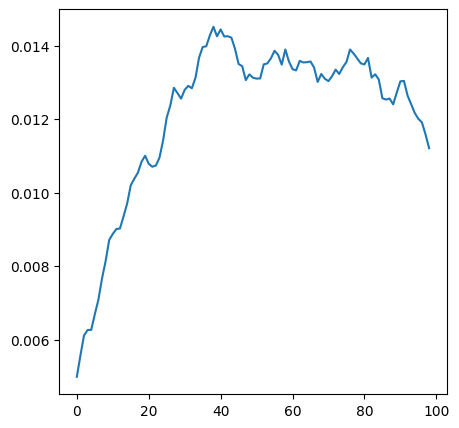

In [ ]:
plt.plot(msd[1:]-msd[:-1])

In [ ]:
#jeigu stipriai varai zemyn nubrauk tas vertes!

#tarkem jeigu 10 zingsiu nedideji tada nubraukem.
#cia visada biski maziej..


# balto triukšmo tsg tie dlykai


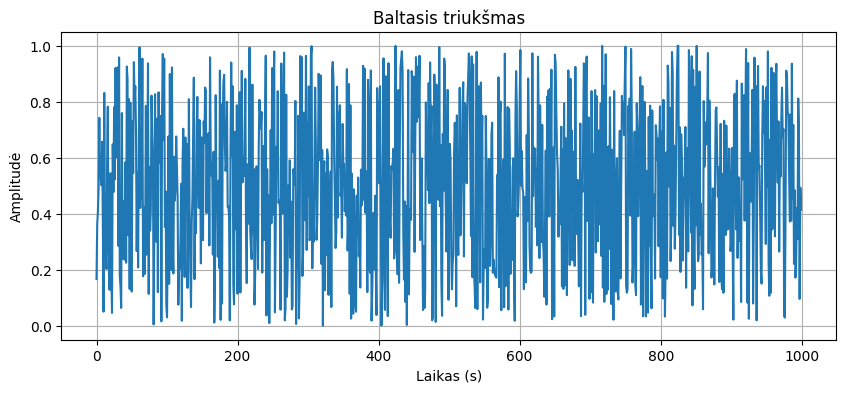

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Parametrai
trukmė = 1000  # Duomenų taškų skaičius
pavyzdžių_dažnis = 1  # Pavyzdžių dažnis, bet kuriuo atveju čia 1Hz

# Sugeneruoti baltąjį triukšmą
baltasis_triukšmas = np.random.uniform(0, 1, trukmė)

# Laiko ašis
laikas = np.arange(0, trukmė) / pavyzdžių_dažnis

# Nubraižyti grafiką
plt.figure(figsize=(10, 4))
plt.plot(laikas, baltasis_triukšmas)
plt.title("Baltasis triukšmas")
plt.xlabel("Laikas (s)")
plt.ylabel("Amplitudė")
plt.grid(True)
plt.show()


In [24]:
myMSD(baltasis_triukšmas)

-0.0014327867333690564

In [25]:
myRS(baltasis_triukšmas)

0.09115285081083876

In [26]:
higuchi1(baltasis_triukšmas)

-0.004904010075852838